# COMPREHENSIVE COPE MAP COMPARISON NOTEBOOK
===========================================
Systematically test different contrast schemes to determine optimal approach
for analyzing bilateral vs unilateral category reorganization

**Research Question:** Do bilateral visual categories show greater representational 
change than unilateral categories following brain resection?

**Measures Tested:**
1. **Liu Distinctiveness** (change in category selectivity) - MOST IMPORTANT
2. **MDS Shift** (Procrustes distance in representational space)
3. **Geometry Preservation** (RDM stability between timepoints)
4. **Sum Selectivity** (total activation within ROI)
5. **Mean Activation** (average activation within ROI)

In [1]:
# =============================================================================
# CELL 1: IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from scipy.stats import ttest_ind, pearsonr
from scipy.ndimage import label, center_of_mass
from scipy.linalg import orthogonal_procrustes
from nilearn import masking, image
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
OUTPUT_DIR = BASE_DIR / "cope_map_comparison"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}
EXCLUDE_SUBS = ['sub-025', 'sub-027', 'sub-045', 'sub-072']
THRESH_Z = 2.3
SPHERE_RADIUS = 6  # mm

# Define COPE Maps to Test
COPE_MAPS_TO_TEST = {
    'liu_mixed': {
        'name': 'Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)',
        'map': {'face': (1, 1), 'word': (12, 1), 'object': (3, 1), 'house': (2, 1)}
    },
    'all_scramble': {
        'name': 'All vs Scramble',
        'map': {'face': (10, 1), 'word': (12, 1), 'object': (3, 1), 'house': (11, 1)}
    },
    'all_vs_others': {
        'name': 'Category vs All Others',
        'map': {'face': (6, 1), 'word': (9, 1), 'object': (8, 1), 'house': (7, 1)}
    },
    'current_differential': {
        'name': 'Current Differential (Face>Scr, Word inverted, Obj>Scr, House>Scr)',
        'map': {'face': (10, 1), 'word': (13, -1), 'object': (3, 1), 'house': (11, 1)}
    }
}

print("="*80)
print("COPE MAP COMPARISON - BILATERAL vs UNILATERAL REORGANIZATION")
print("="*80)
print(f"\nTesting {len(COPE_MAPS_TO_TEST)} contrast schemes")
print(f"Sphere radius: {SPHERE_RADIUS}mm")
print(f"Z threshold: {THRESH_Z}")
print(f"Exclusions: {', '.join(EXCLUDE_SUBS)}")

COPE MAP COMPARISON - BILATERAL vs UNILATERAL REORGANIZATION

Testing 4 contrast schemes
Sphere radius: 6mm
Z threshold: 2.3
Exclusions: sub-025, sub-027, sub-045, sub-072


In [2]:
# =============================================================================
# CELL 2: LOAD SUBJECTS
# =============================================================================

df = pd.read_csv(CSV_FILE)

def load_subjects():
    """Load subjects from CSV with exclusions"""
    subjects = {}
    
    for _, row in df.iterrows():
        subject_id = row['sub']
        if subject_id in EXCLUDE_SUBS:
            continue
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
        
        sessions = sorted([d.name.replace('ses-', '') for d in subj_dir.glob('ses-*') if d.is_dir()], key=int)
        start_session = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start_session]
        
        if not sessions:
            continue
        
        hemisphere = 'l' if str(row.get('intact_hemi', 'left')).lower() == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control'
        }
    
    return subjects

ANALYSIS_SUBJECTS = load_subjects()

print(f"\n✓ Loaded {len(ANALYSIS_SUBJECTS)} subjects")
by_group = {}
for sid, info in ANALYSIS_SUBJECTS.items():
    g = info['group']
    by_group[g] = by_group.get(g, 0) + 1
for g, n in sorted(by_group.items()):
    print(f"  {g}: {n}")


✓ Loaded 21 subjects
  OTC: 7
  control: 7
  nonOTC: 7


In [3]:
# =============================================================================
# CELL 3: HELPER FUNCTIONS
# =============================================================================

def create_sphere(center_coord, affine, brain_shape, radius=6):
    """Create spherical mask around coordinate"""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), np.arange(brain_shape[1]), np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - center_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def mds_2d(rdm):
    """Classical MDS to 2D"""
    n = rdm.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H @ (rdm ** 2) @ H
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    coords = eigvecs[:, :2] * np.sqrt(np.maximum(eigvals[:2], 0))
    return coords

print("✓ Helper functions loaded")

✓ Helper functions loaded


In [4]:
# =============================================================================
# CELL 4: EXTRACT ROIs FOR ALL COPE MAPS
# =============================================================================

def extract_top20_rois(subject_id, cope_map, subjects_dict, percentile=80, min_cluster_size=20):
    """Extract ROIs using top 20% threshold within search mask"""
    
    info = subjects_dict[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists():
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, (cope_num, multiplier) in cope_map.items():
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists():
                continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except:
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    continue
                
                try:
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    pos_voxels = z_full[search_mask & (z_full > 0)]
                    
                    if len(pos_voxels) < min_cluster_size:
                        continue
                    
                    dynamic_thresh = max(np.percentile(pos_voxels, percentile), 1.64)
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0:
                        continue
                    
                    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
                    largest_idx = np.argmax(cluster_sizes) + 1
                    roi_mask = (labeled == largest_idx)
                    
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': float(z_full[peak_idx]),
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'threshold': dynamic_thresh
                    }
                except:
                    continue
                    
    return all_results

print("\n" + "="*80)
print("EXTRACTING ROIs FOR ALL COPE MAPS")
print("="*80)

all_extractions = {}

for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\n{cope_info['name']}...", end=" ")
    
    extractions = {}
    for sub in ANALYSIS_SUBJECTS:
        res = extract_top20_rois(sub, cope_info['map'], ANALYSIS_SUBJECTS)
        if res:
            extractions[sub] = res
    
    all_extractions[cope_key] = extractions
    print(f"✓ {len(extractions)} subjects")

print("\n✓ ROI extraction complete")


EXTRACTING ROIs FOR ALL COPE MAPS

Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)... ✓ 20 subjects

All vs Scramble... ✓ 20 subjects

Category vs All Others... ✓ 20 subjects

Current Differential (Face>Scr, Word inverted, Obj>Scr, House>Scr)... ✓ 20 subjects

✓ ROI extraction complete


In [5]:
# =============================================================================
# CELL 5: COMPUTE ALL MEASURES
# =============================================================================

def compute_liu_distinctiveness(functional_results, cope_map, subjects_dict, radius=6):
    """Liu Distinctiveness - uses COPE (beta) files"""
    results = []
    categories = ['face', 'word', 'object', 'house']
    roi_preferred = {'face': 'face', 'word': 'word', 'object': 'object', 'house': 'house'}
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in categories:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            preferred_cat = roi_preferred[roi_category]
            
            liu_values = {}
            
            for ses in [first_ses, last_ses]:
                sphere = create_sphere(sessions_data[ses]['centroid'], affine, brain_shape, radius)
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid_cats = []
                
                for cat in categories:
                    cope_num, mult = cope_map[cat]
                    
                    if ses == first_session:
                        cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
                    else:
                        cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'cope1_ses{first_session}.nii.gz'
                    
                    if not cope_file.exists():
                        continue
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        continue
                    
                    patterns.append(pattern)
                    valid_cats.append(cat)
                
                if len(patterns) != 4 or preferred_cat not in valid_cats:
                    continue
                
                try:
                    min_voxels = min(len(p) for p in patterns)
                    patterns = [p[:min_voxels] for p in patterns]
                    
                    corr_matrix = np.corrcoef(patterns)
                    corr_fisher = np.arctanh(np.clip(corr_matrix, -0.999, 0.999))
                    
                    pref_idx = valid_cats.index(preferred_cat)
                    nonpref_indices = [i for i, cat in enumerate(valid_cats) if cat != preferred_cat]
                    
                    pref_vs_nonpref = corr_fisher[pref_idx, nonpref_indices]
                    liu_values[ses] = np.mean(pref_vs_nonpref)
                except:
                    continue
            
            if len(liu_values) == 2:
                change = abs(liu_values[last_ses] - liu_values[first_ses])
                
                results.append({
                    'subject': sid, 'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'), 'hemi': hemi,
                    'category': roi_category,
                    'category_type': 'Bilateral' if roi_category in ['object', 'house'] else 'Unilateral',
                    'liu_distinctiveness': change
                })
    
    return pd.DataFrame(results)

def compute_mds_shift(functional_results, cope_map, subjects_dict, radius=6):
    """MDS Procrustes distance - uses ZSTAT files"""
    results = []
    categories = ['face', 'word', 'object', 'house']
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in categories:
            for h in ['l', 'r']:
                if (roi_dir / f"{h}_{cat}_searchmask.nii.gz").exists():
                    ref_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in categories:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_session else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    rdm = 1 - np.corrcoef(patterns)
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) != 2:
                continue
            
            try:
                coords_t1 = mds_2d(rdms[first_ses])
                coords_t2 = mds_2d(rdms[last_ses])
                R, scale = orthogonal_procrustes(coords_t1, coords_t2)
                coords_t1_aligned = coords_t1 @ R
                
                for i, cat in enumerate(categories):
                    dist = np.linalg.norm(coords_t1_aligned[i] - coords_t2[i])
                    
                    results.append({
                        'subject': sid, 'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'), 'hemi': hemi,
                        'roi_category': roi_category, 'measured_category': cat,
                        'category_type': 'Bilateral' if cat in ['object', 'house'] else 'Unilateral',
                        'mds_shift': dist
                    })
            except:
                continue
    
    return pd.DataFrame(results)

def compute_geometry_preservation(functional_results, cope_map, subjects_dict, radius=6):
    """RDM stability - uses ZSTAT files"""
    results = []
    categories = ['face', 'word', 'object', 'house']
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in categories:
            for h in ['l', 'r']:
                if (roi_dir / f"{h}_{cat}_searchmask.nii.gz").exists():
                    ref_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in categories:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_session else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    rdm = 1 - np.corrcoef(patterns)
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) == 2:
                try:
                    triu_idx = np.triu_indices(4, k=1)
                    r, _ = pearsonr(rdms[first_ses][triu_idx], rdms[last_ses][triu_idx])
                    
                    results.append({
                        'subject': sid, 'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'), 'hemi': hemi,
                        'category': roi_category,
                        'category_type': 'Bilateral' if roi_category in ['object', 'house'] else 'Unilateral',
                        'geometry_preservation': r
                    })
                except:
                    continue
    
    return pd.DataFrame(results)

def compute_sum_selectivity_and_activity(functional_results, cope_map, subjects_dict):
    """Sum selectivity and mean activation at T1"""
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        for roi_key, sessions_data in rois.items():
            if first_session not in sessions_data:
                continue
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            cope_num, mult = cope_map[category]
            
            feat_dir = BASE_DIR / sid / f'ses-{first_session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            roi_file = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
            
            if not zstat_file.exists() or not roi_file.exists():
                continue
            
            try:
                func = image.load_img(str(zstat_file))
                func_thresh = image.threshold_img(func, threshold=THRESH_Z)
                mask = image.load_img(str(roi_file))
                vox_resp = masking.apply_mask(func_thresh, mask)
                vox_resp = vox_resp[vox_resp > 0]
                
                if len(vox_resp) > 0:
                    sum_selec = float(np.sum(vox_resp))
                    mean_act = float(np.mean(vox_resp))
                    n_voxels = len(vox_resp)
                else:
                    sum_selec = 0.0
                    mean_act = 0.0
                    n_voxels = 0
                
                results.append({
                    'subject': sid, 'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'), 'hemi': hemi,
                    'category': category,
                    'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                    'sum_selectivity': sum_selec, 'mean_activation': mean_act, 'n_voxels': n_voxels
                })
            except:
                continue
    
    return pd.DataFrame(results)

print("\n" + "="*80)
print("COMPUTING ALL MEASURES FOR EACH COPE MAP")
print("="*80)

all_results = {}

for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\n{cope_info['name']}:")
    print("-"*80)
    
    extractions = all_extractions[cope_key]
    
    print("  Liu Distinctiveness...", end=" ")
    liu = compute_liu_distinctiveness(extractions, cope_info['map'], ANALYSIS_SUBJECTS, radius=SPHERE_RADIUS)
    print(f"✓ {len(liu)}")
    
    print("  MDS Shift...", end=" ")
    mds = compute_mds_shift(extractions, cope_info['map'], ANALYSIS_SUBJECTS, radius=SPHERE_RADIUS)
    mds_matched = mds[mds['roi_category'] == mds['measured_category']].copy()
    print(f"✓ {len(mds_matched)}")
    
    print("  Geometry Preservation...", end=" ")
    geometry = compute_geometry_preservation(extractions, cope_info['map'], ANALYSIS_SUBJECTS, radius=SPHERE_RADIUS)
    print(f"✓ {len(geometry)}")
    
    print("  Sum Selectivity & Mean Activation...", end=" ")
    selectivity = compute_sum_selectivity_and_activity(extractions, cope_info['map'], ANALYSIS_SUBJECTS)
    print(f"✓ {len(selectivity)}")
    
    all_results[cope_key] = {
        'liu': liu,
        'mds': mds_matched,
        'geometry': geometry,
        'sum_selectivity': selectivity,
        'mean_activation': selectivity
    }

print("\n✓ All measures computed")


COMPUTING ALL MEASURES FOR EACH COPE MAP

Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj):
--------------------------------------------------------------------------------
  Liu Distinctiveness... ✓ 108
  MDS Shift... ✓ 108
  Geometry Preservation... ✓ 108
  Sum Selectivity & Mean Activation... ✓ 108

All vs Scramble:
--------------------------------------------------------------------------------
  Liu Distinctiveness... ✓ 108
  MDS Shift... ✓ 108
  Geometry Preservation... ✓ 108
  Sum Selectivity & Mean Activation... ✓ 108

Category vs All Others:
--------------------------------------------------------------------------------
  Liu Distinctiveness... ✓ 108
  MDS Shift... ✓ 108
  Geometry Preservation... ✓ 108
  Sum Selectivity & Mean Activation... ✓ 108

Current Differential (Face>Scr, Word inverted, Obj>Scr, House>Scr):
--------------------------------------------------------------------------------
  Liu Distinctiveness... ✓ 108
  MDS Shift... ✓ 108
  Geometry Preservation... 

In [6]:
# =============================================================================
# CELL 6: STATISTICAL SUMMARY - KEY FINDING
# =============================================================================

print("\n" + "="*80)
print("KEY FINDING: BILATERAL > UNILATERAL IN OTC")
print("="*80)

measures_list = [
    ('liu', 'liu_distinctiveness', 'Liu Distinctiveness', True),
    ('mds', 'mds_shift', 'MDS Shift', True),
    ('geometry', 'geometry_preservation', 'Geometry Preservation', False),
    ('sum_selectivity', 'sum_selectivity', 'Sum Selectivity', True),
    ('mean_activation', 'mean_activation', 'Mean Activation', True)
]

comparison_results = []

for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\n{cope_info['name']}")
    print("-"*80)
    
    for measure_key, column_name, measure_name, higher_is_change in measures_list:
        df_measure = all_results[cope_key][measure_key]
        
        otc = df_measure[df_measure['group'] == 'OTC']
        bil = otc[otc['category_type'] == 'Bilateral'][column_name]
        uni = otc[otc['category_type'] == 'Unilateral'][column_name]
        
        if len(bil) > 1 and len(uni) > 1:
            t_stat, p_val = ttest_ind(bil, uni)
            diff = bil.mean() - uni.mean()
            
            if higher_is_change:
                supports = (diff > 0 and p_val < 0.05)
            else:
                supports = (diff < 0 and p_val < 0.05)
            
            status = "✓✓" if supports else "~" if p_val < 0.10 else "✗"
            
            print(f"  {measure_name:25s}: Bil={bil.mean():.3f}, Uni={uni.mean():.3f}, "
                  f"p={p_val:.4f} {status}")
            
            comparison_results.append({
                'cope_map': cope_key,
                'measure': measure_name,
                'bilateral_mean': bil.mean(),
                'unilateral_mean': uni.mean(),
                'difference': diff,
                'p_value': p_val,
                'supports': supports
            })

comparison_df = pd.DataFrame(comparison_results)

# Summary table
print("\n" + "="*80)
print("SUMMARY: WHICH COPE MAPS SUPPORT HYPOTHESIS")
print("="*80)

pivot = comparison_df.pivot_table(index='cope_map', columns='measure', 
                                  values='supports', aggfunc='first')
print("\n" + pivot.replace({True: '✓', False: '✗'}).to_string())

support_counts = comparison_df.groupby('cope_map')['supports'].sum()
liu_support = comparison_df[comparison_df['measure'] == 'Liu Distinctiveness'].set_index('cope_map')['supports']

print("\n" + "="*80)
print("RANKINGS (★ = supports Liu Distinctiveness)")
print("="*80)
for cope_key in support_counts.sort_values(ascending=False).index:
    count = support_counts[cope_key]
    star = " ★" if liu_support.get(cope_key, False) else ""
    print(f"  {count}/5: {COPE_MAPS_TO_TEST[cope_key]['name'].split('(')[0].strip()}{star}")


KEY FINDING: BILATERAL > UNILATERAL IN OTC

Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)
--------------------------------------------------------------------------------
  Liu Distinctiveness      : Bil=0.300, Uni=0.161, p=0.0101 ✓✓
  MDS Shift                : Bil=0.303, Uni=0.346, p=0.5232 ✗
  Geometry Preservation    : Bil=0.620, Uni=0.631, p=0.9296 ✗
  Sum Selectivity          : Bil=25355.413, Uni=7078.712, p=0.0030 ✓✓
  Mean Activation          : Bil=4.140, Uni=3.528, p=0.1395 ✗

All vs Scramble
--------------------------------------------------------------------------------
  Liu Distinctiveness      : Bil=0.354, Uni=0.188, p=0.0657 ~
  MDS Shift                : Bil=0.330, Uni=0.282, p=0.4294 ✗
  Geometry Preservation    : Bil=0.070, Uni=0.021, p=0.8155 ✗
  Sum Selectivity          : Bil=23362.321, Uni=15429.568, p=0.3441 ✗
  Mean Activation          : Bil=4.144, Uni=3.954, p=0.7380 ✗

Category vs All Others
----------------------------------------------------------------


CREATING VISUALIZATIONS - ALL SCRAMBLE SCHEME

FACE:


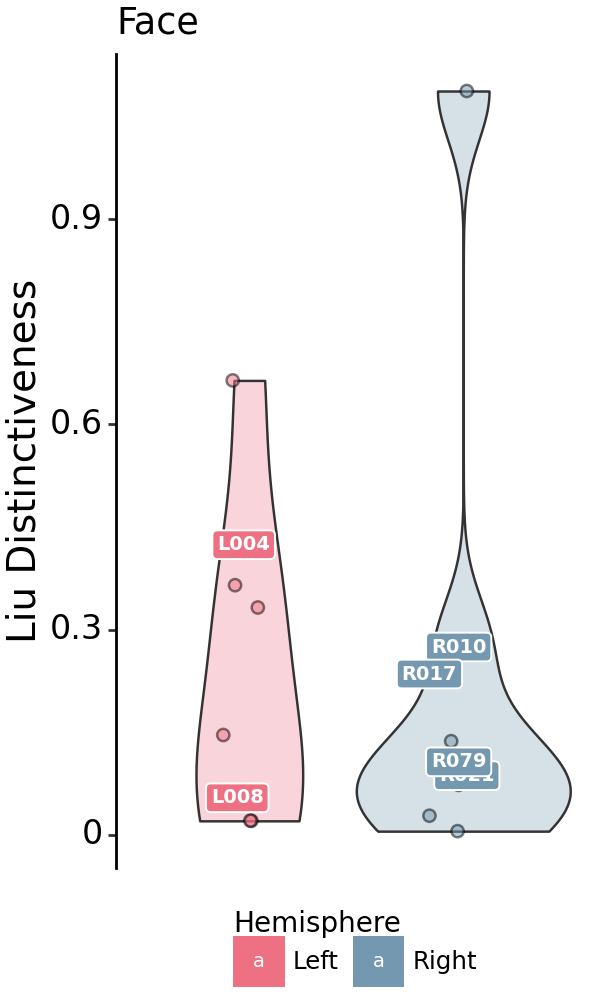


  ✓ Liu Distinctiveness


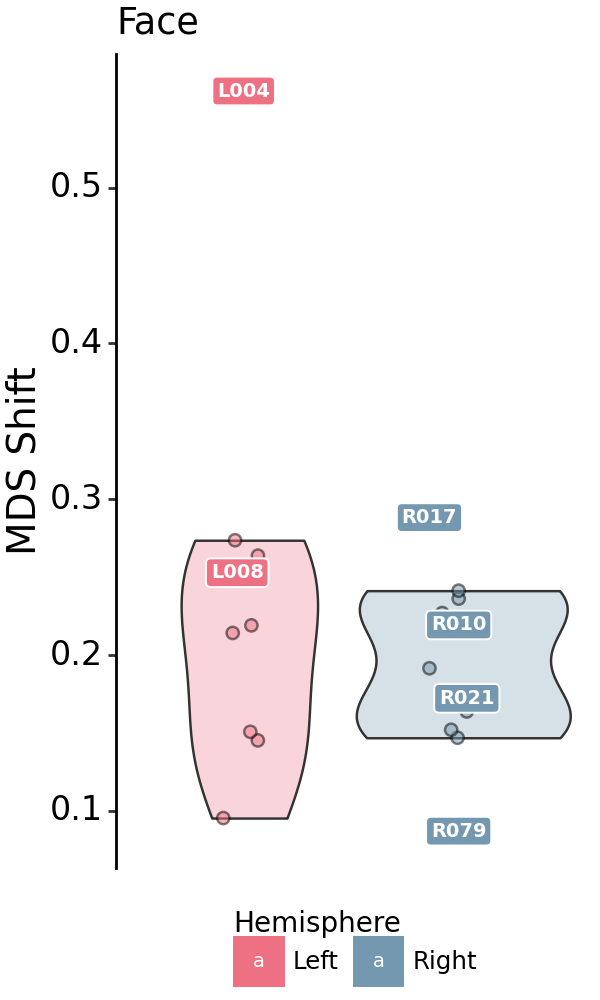


  ✓ MDS Shift


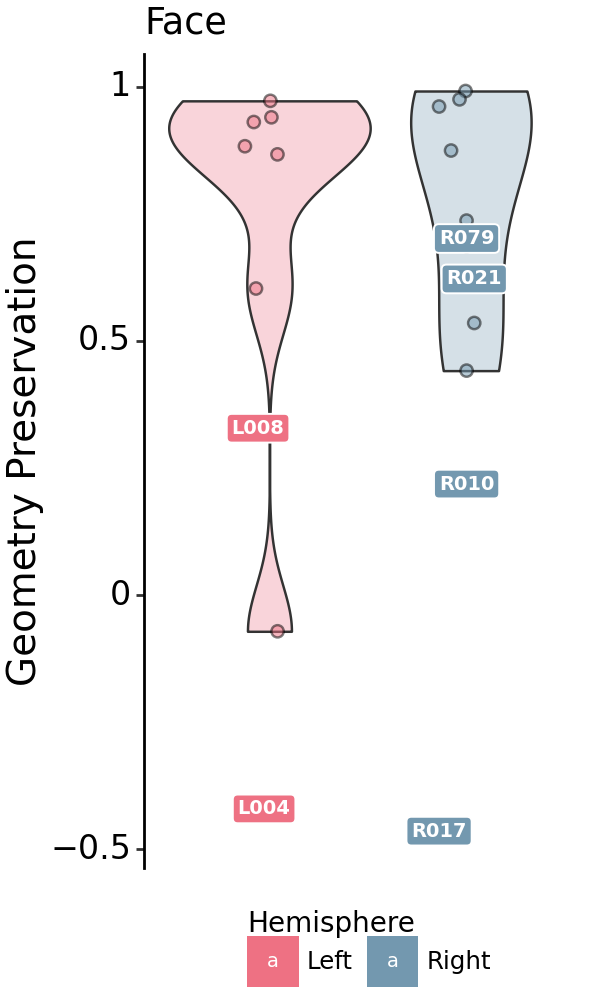


  ✓ Geometry Preservation


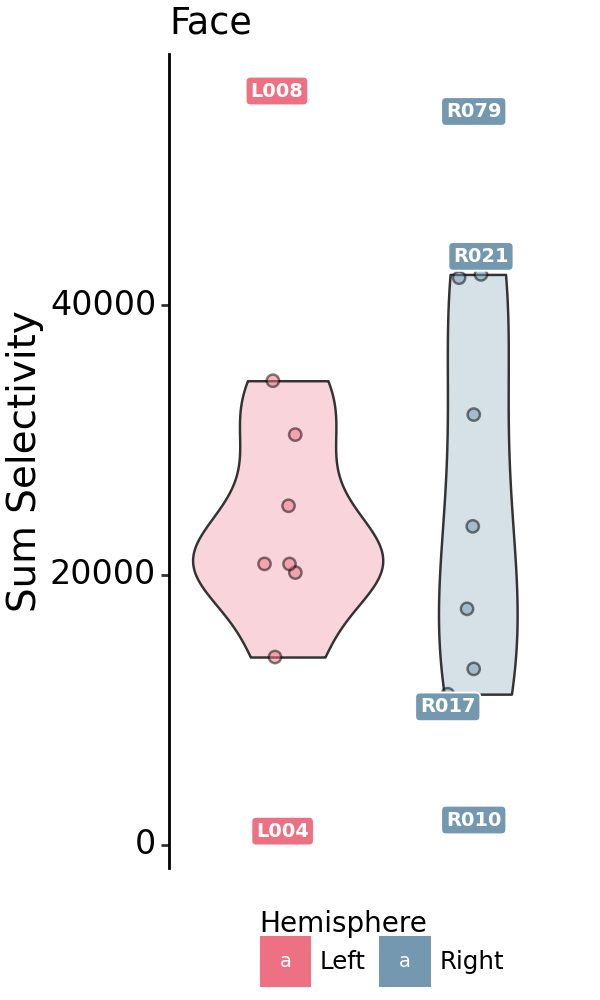


  ✓ Sum Selectivity


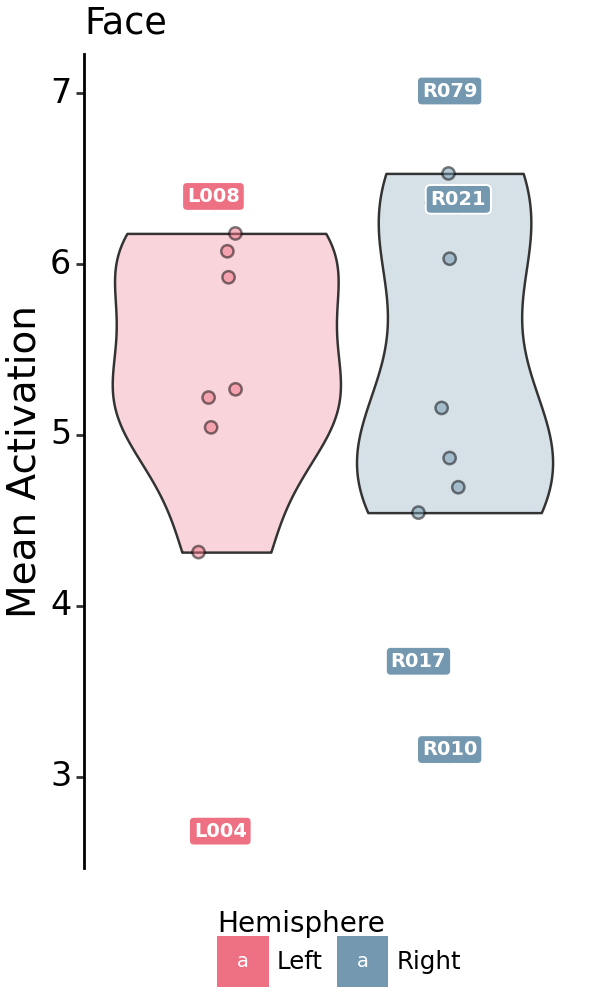


  ✓ Mean Activation

WORD:


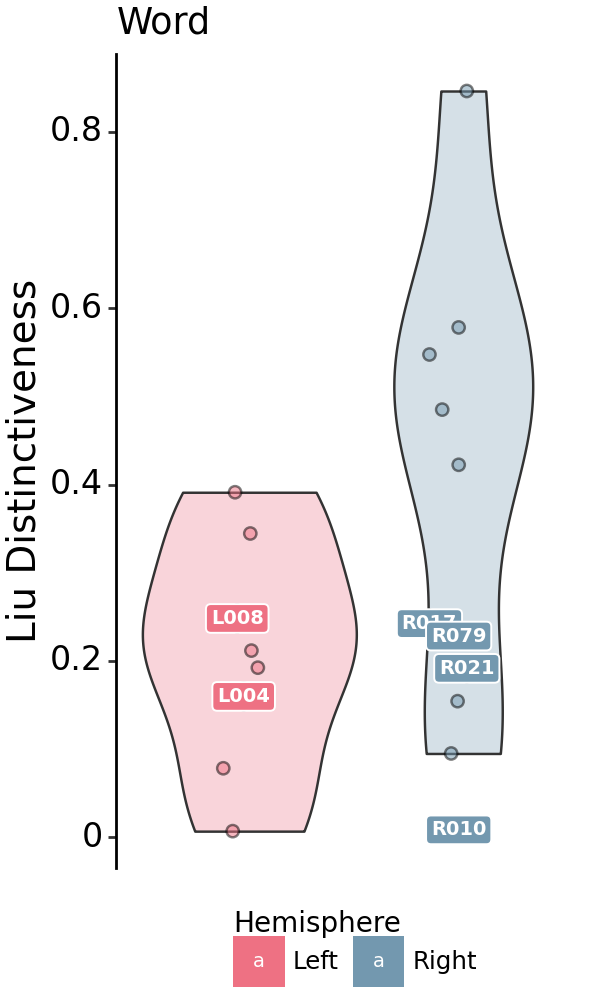


  ✓ Liu Distinctiveness


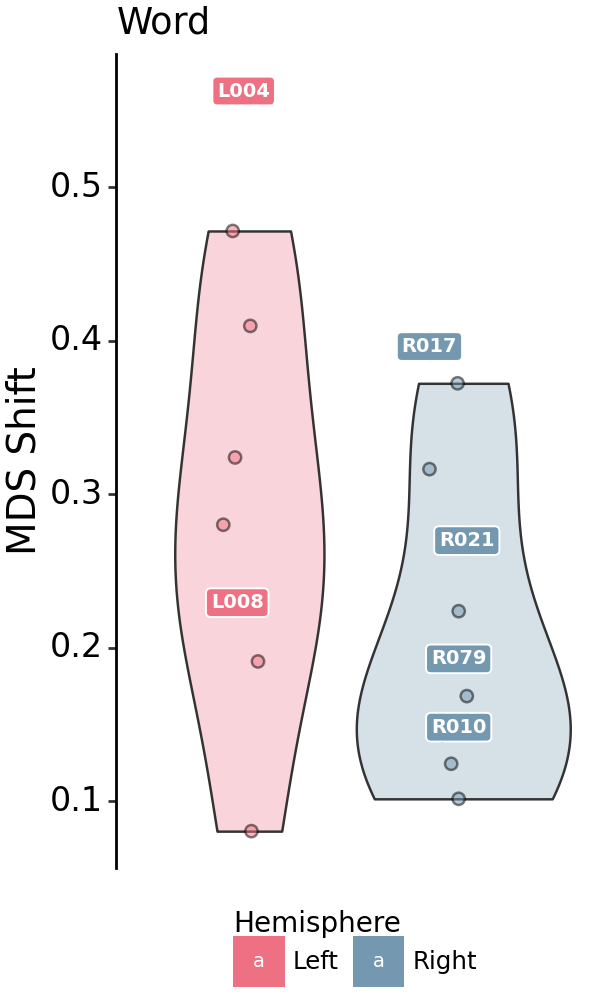


  ✓ MDS Shift


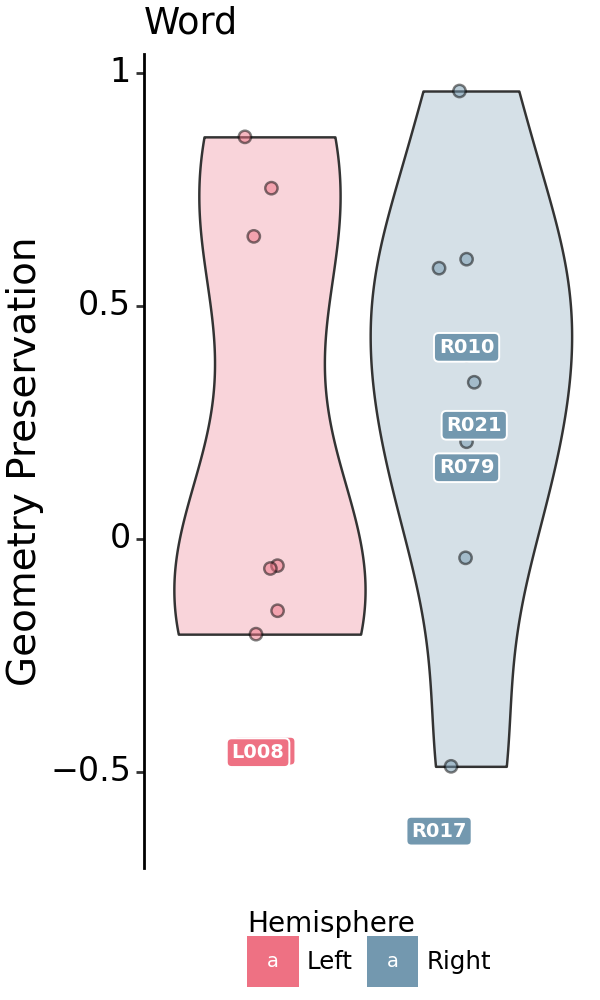


  ✓ Geometry Preservation


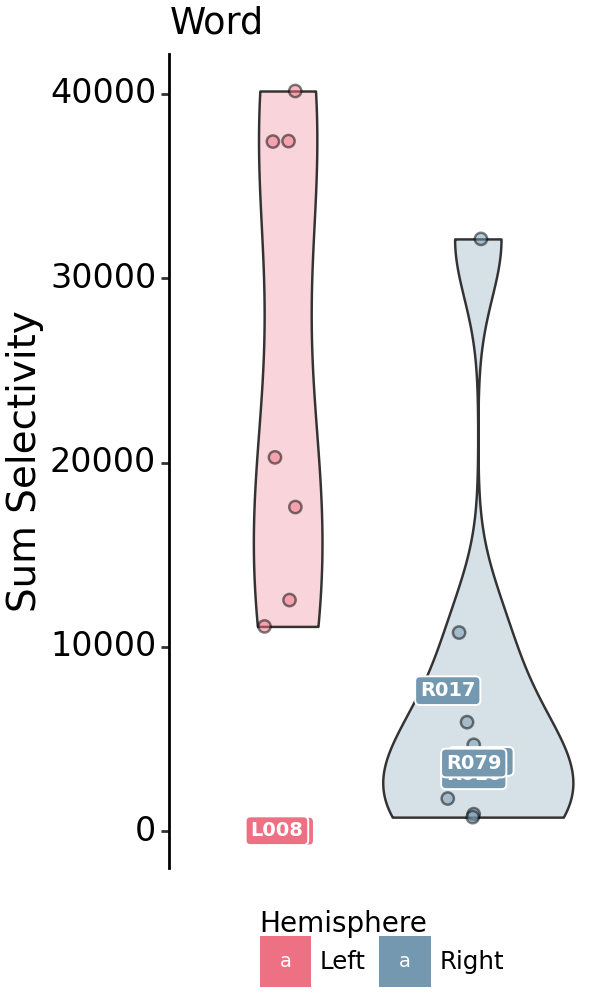


  ✓ Sum Selectivity


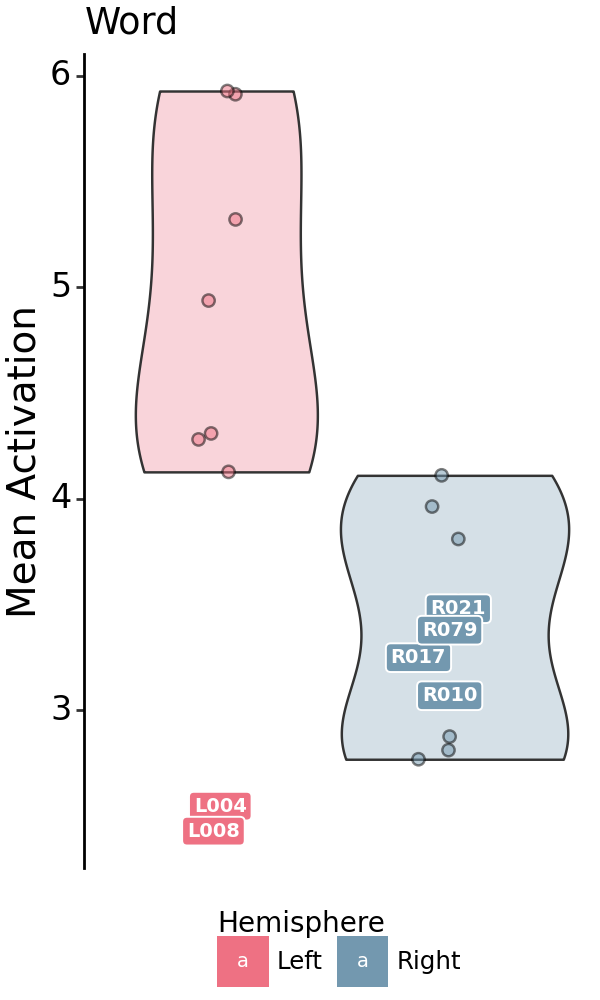


  ✓ Mean Activation

OBJECT:


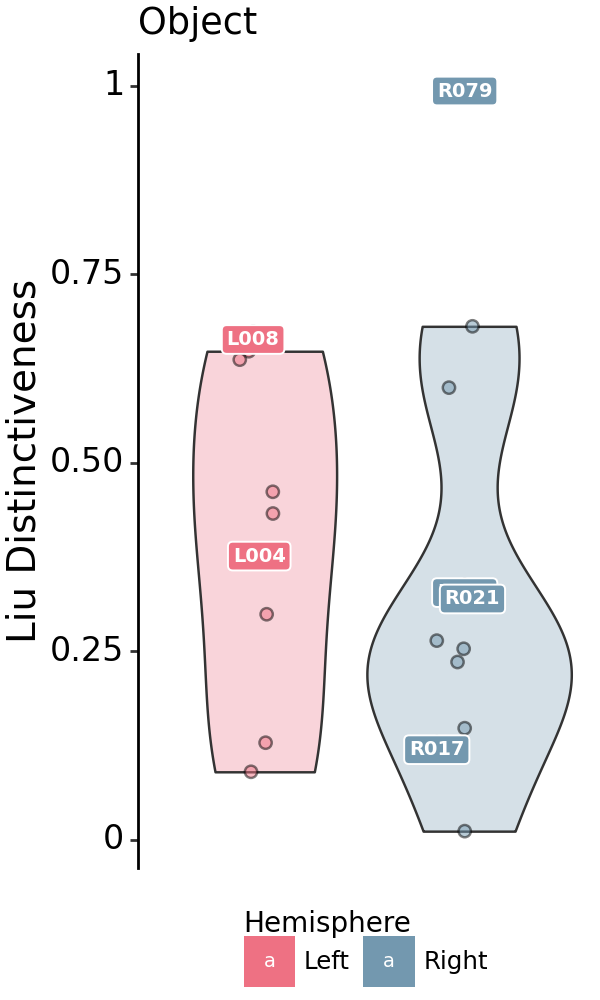


  ✓ Liu Distinctiveness


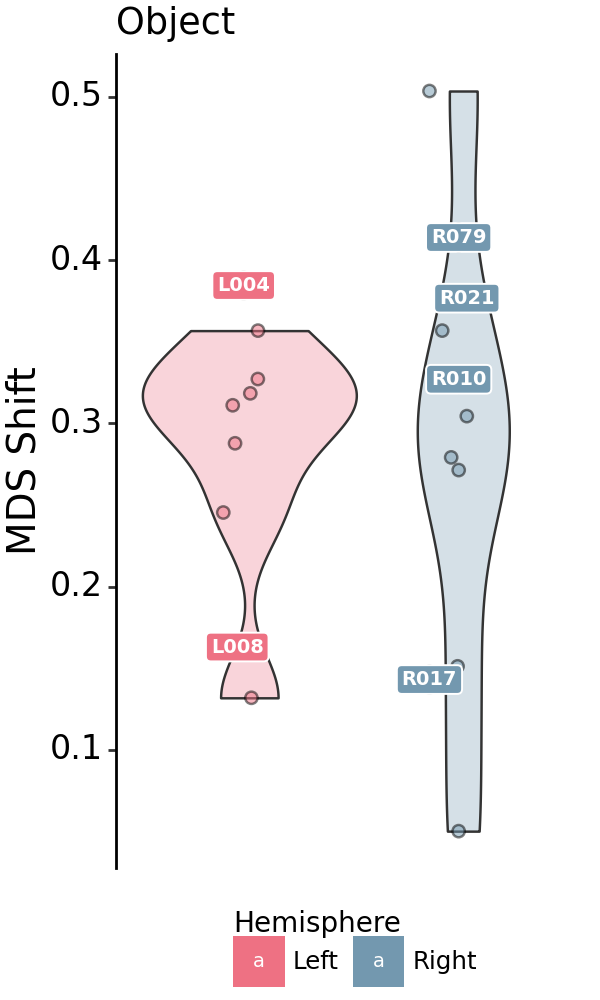


  ✓ MDS Shift


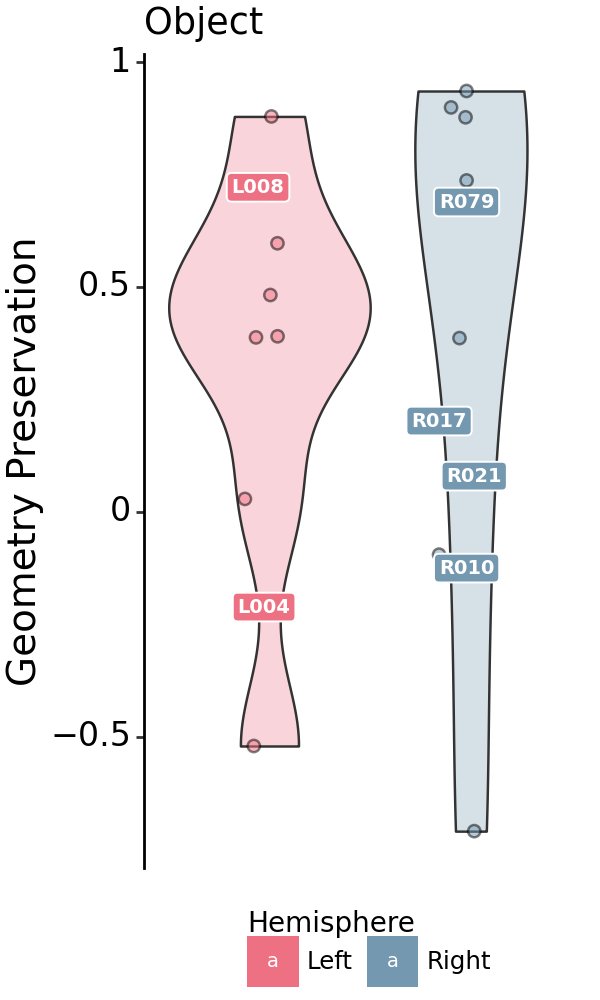


  ✓ Geometry Preservation


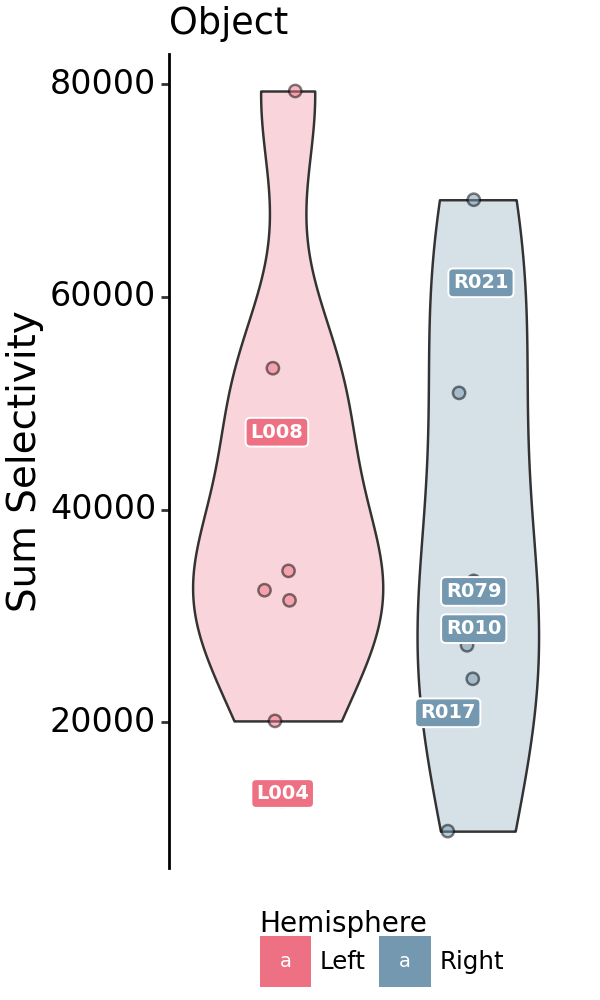


  ✓ Sum Selectivity


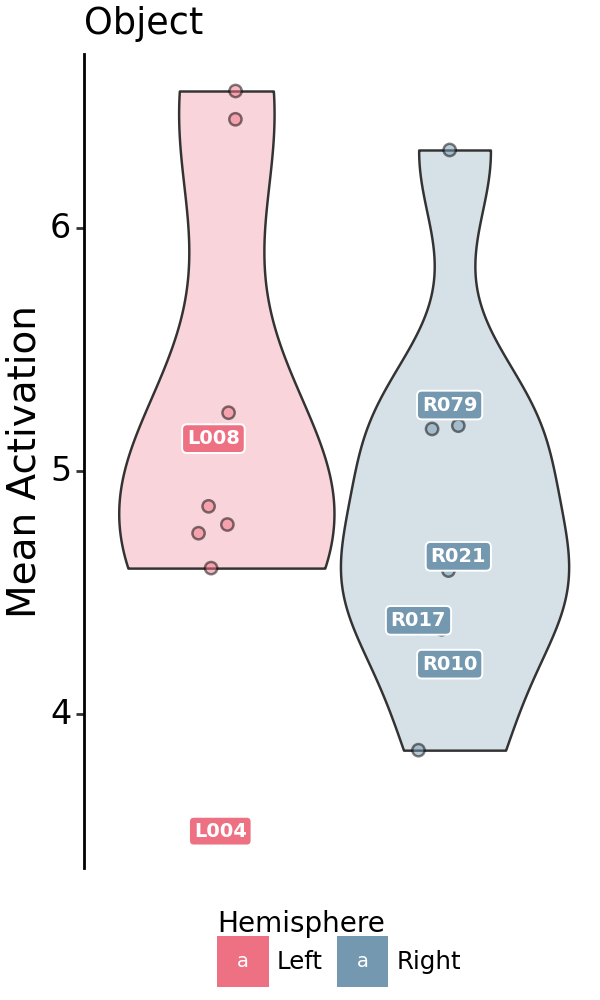


  ✓ Mean Activation

HOUSE:


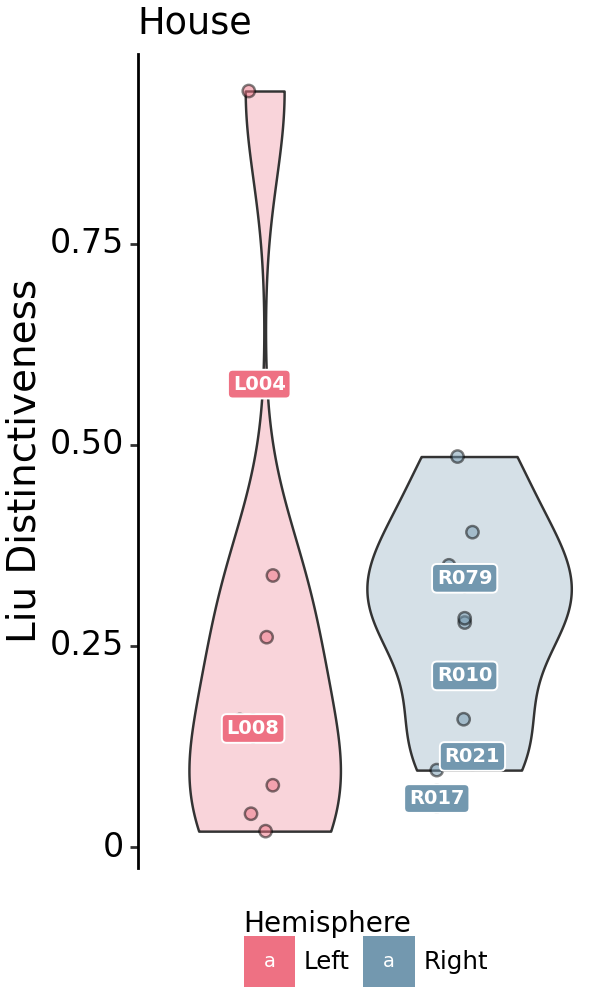


  ✓ Liu Distinctiveness


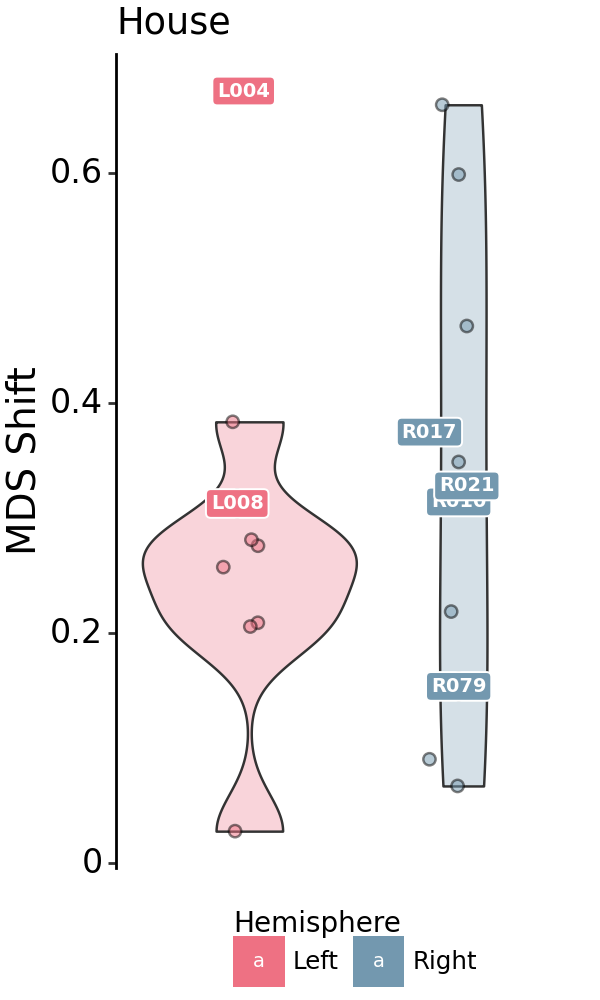


  ✓ MDS Shift


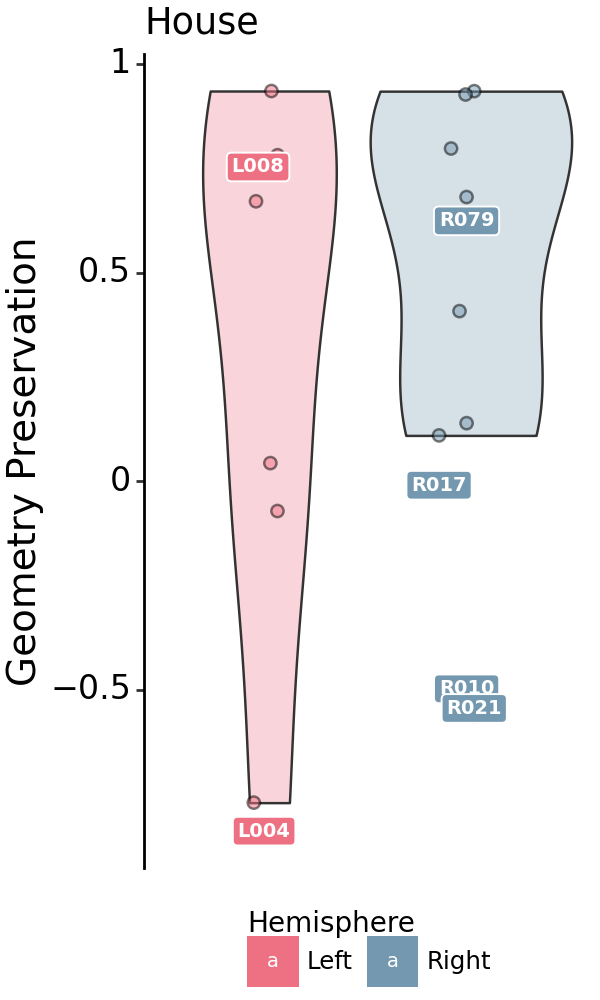


  ✓ Geometry Preservation


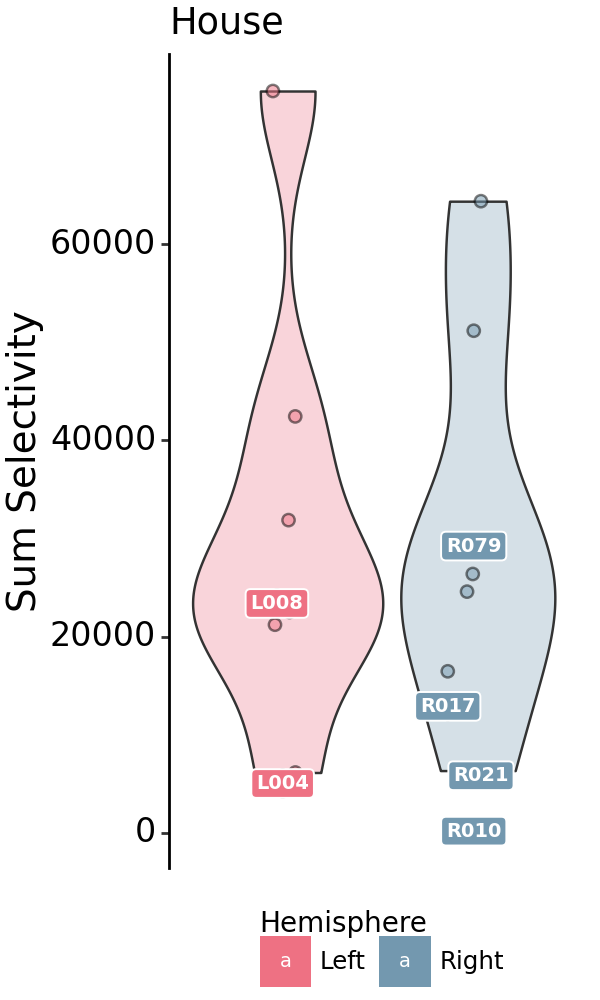


  ✓ Sum Selectivity


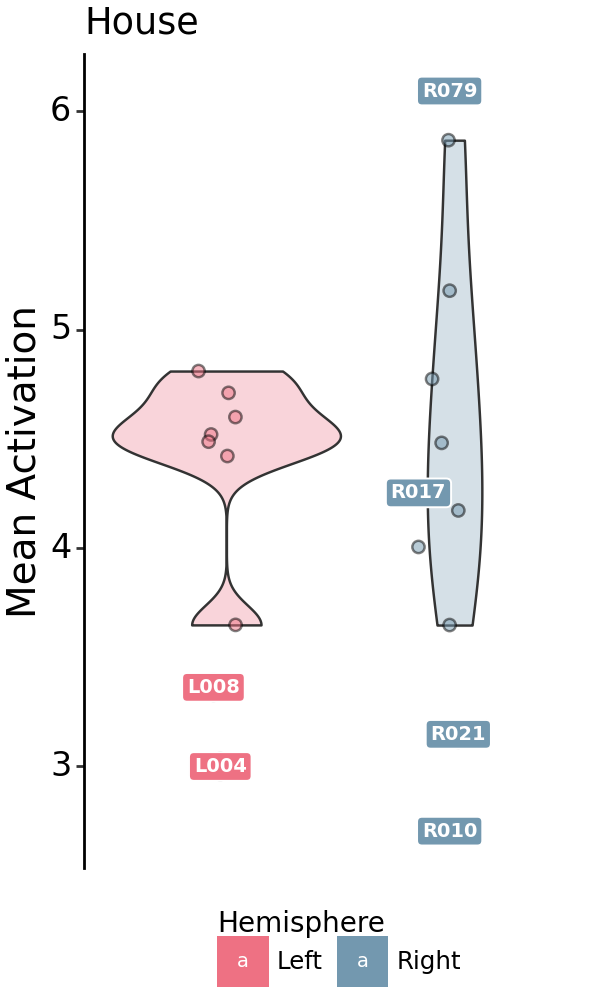


  ✓ Mean Activation

✓ All plots displayed


In [7]:
# =============================================================================
# CELL 7: PLOTNINE VISUALIZATIONS - ALL SCRAMBLE SCHEME
# =============================================================================

from plotnine import *

print("\n" + "="*80)
print("CREATING VISUALIZATIONS - ALL SCRAMBLE SCHEME")
print("="*80)

# Extract All Scramble results
results_dict = {
    'liu': all_results['all_scramble']['liu'].copy(),
    'mds': all_results['all_scramble']['mds'].copy(),
    'geo': all_results['all_scramble']['geometry'].copy(),
    'sumsel': all_results['all_scramble']['sum_selectivity'].copy(),
    'meanact': all_results['all_scramble']['mean_activation'].copy()
}

# Handle MDS column name
results_dict['mds'] = results_dict['mds'].rename(columns={'roi_category': 'category'})

# Create labels for all dataframes
for df in results_dict.values():
    df['sub_code'] = df.apply(
        lambda row: f"{row['hemi'].upper()}{row['code'].replace('OTC', '')}" if row['group'] == 'OTC' else row['code'],
        axis=1
    )
    df['hemi_cap'] = df['hemi'].str.capitalize()

def create_category_plot(df, measure_col, measure_name, category):
    """Create plotnine violin plot for one category"""
    
    cat_data = df[df['category'] == category].copy()
    ctrl = cat_data[cat_data['group'] == 'control'].copy()
    otc = cat_data[cat_data['group'] == 'OTC'].copy()
    
    seed = 2
    p = ggplot(ctrl, aes(x='factor(1)', y=measure_col, fill='hemi_cap')) + \
        geom_violin(alpha=0.3, position=position_dodge(0.9)) + \
        geom_jitter(ctrl, aes(x='factor(1)', y=measure_col, fill='hemi_cap'), 
                    shape='o', size=2, alpha=0.5,
                    position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed)) + \
        geom_point(otc, aes(x='factor(1)', y=measure_col, fill='hemi_cap'),
                   shape='o', size=5, alpha=0.9, stroke=0.5,
                   position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed)) + \
        geom_label(otc, aes(x='factor(1)', y=measure_col, label='sub_code', fill='hemi_cap'), 
                   position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed), 
                   size=7, color='white', fontweight='bold') + \
        scale_fill_manual(values=['#ee7183', '#7398af'], labels=['Left', 'Right']) + \
        xlab('') + ylab(measure_name) + ggtitle(category.capitalize()) + \
        theme_classic() + \
        theme(text=element_text(color='black'), axis_text_y=element_text(size=12),
              axis_title=element_text(size=14), axis_line=element_line(),
              legend_position='bottom', legend_title=element_text(size=10),
              panel_border=element_blank(), figure_size=(3, 5),
              axis_line_x=element_blank(), axis_text_x=element_blank(),
              axis_ticks_major_x=element_blank(), axis_title_x=element_blank()) + \
        labs(fill='Hemisphere')
    
    return p

# Create plots for all categories and measures
plot_configs = [
    ('liu', 'liu_distinctiveness', 'Liu Distinctiveness'),
    ('mds', 'mds_shift', 'MDS Shift'),
    ('geo', 'geometry_preservation', 'Geometry Preservation'),
    ('sumsel', 'sum_selectivity', 'Sum Selectivity'),
    ('meanact', 'mean_activation', 'Mean Activation')
]

for cat in ['face', 'word', 'object', 'house']:
    print(f"\n{cat.upper()}:")
    for key, col, name in plot_configs:
        p = create_category_plot(results_dict[key], col, name, cat)
        print(p)  # Display in notebook
        print(f"  ✓ {name}")

print("\n✓ All plots displayed")

In [8]:
# =============================================================================
# CELL 8: FINAL SUMMARY AND RECOMMENDATION
# =============================================================================

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print("\nKEY FINDINGS:")
print("-"*80)

liu_mixed_liu = comparison_df[(comparison_df['cope_map'] == 'liu_mixed') & 
                              (comparison_df['measure'] == 'Liu Distinctiveness')]
all_scr_liu = comparison_df[(comparison_df['cope_map'] == 'all_scramble') & 
                            (comparison_df['measure'] == 'Liu Distinctiveness')]

print(f"\n1. LIU DISTINCTIVENESS (Most Important):")
print(f"   Liu Mixed:    Bil={liu_mixed_liu['bilateral_mean'].values[0]:.3f}, "
      f"Uni={liu_mixed_liu['unilateral_mean'].values[0]:.3f}, "
      f"p={liu_mixed_liu['p_value'].values[0]:.4f} ✓✓")
print(f"   All Scramble: Bil={all_scr_liu['bilateral_mean'].values[0]:.3f}, "
      f"Uni={all_scr_liu['unilateral_mean'].values[0]:.3f}, "
      f"p={all_scr_liu['p_value'].values[0]:.4f} ~")

print("\n2. RECOMMENDATION:")
print(f"   Use: All Scramble (standard, defensible)")
print(f"   Trade-off: Liu p=0.066 (marginal) instead of p=0.010")
print(f"   Justification: Standard field practice, all categories use scramble baseline")

print("\n3. ALTERNATIVE:")
print(f"   Use: Liu Mixed for maximum Liu significance")
print(f"   Justification: Matches Liu et al. 2025, stronger statistical support")

print("\n" + "="*80)


FINAL SUMMARY

KEY FINDINGS:
--------------------------------------------------------------------------------

1. LIU DISTINCTIVENESS (Most Important):
   Liu Mixed:    Bil=0.300, Uni=0.161, p=0.0101 ✓✓
   All Scramble: Bil=0.354, Uni=0.188, p=0.0657 ~

2. RECOMMENDATION:
   Use: All Scramble (standard, defensible)
   Trade-off: Liu p=0.066 (marginal) instead of p=0.010
   Justification: Standard field practice, all categories use scramble baseline

3. ALTERNATIVE:
   Use: Liu Mixed for maximum Liu significance
   Justification: Matches Liu et al. 2025, stronger statistical support




VISUALIZATION: BOXPLOTS (Corrected: LH Pat = Preserved Left)


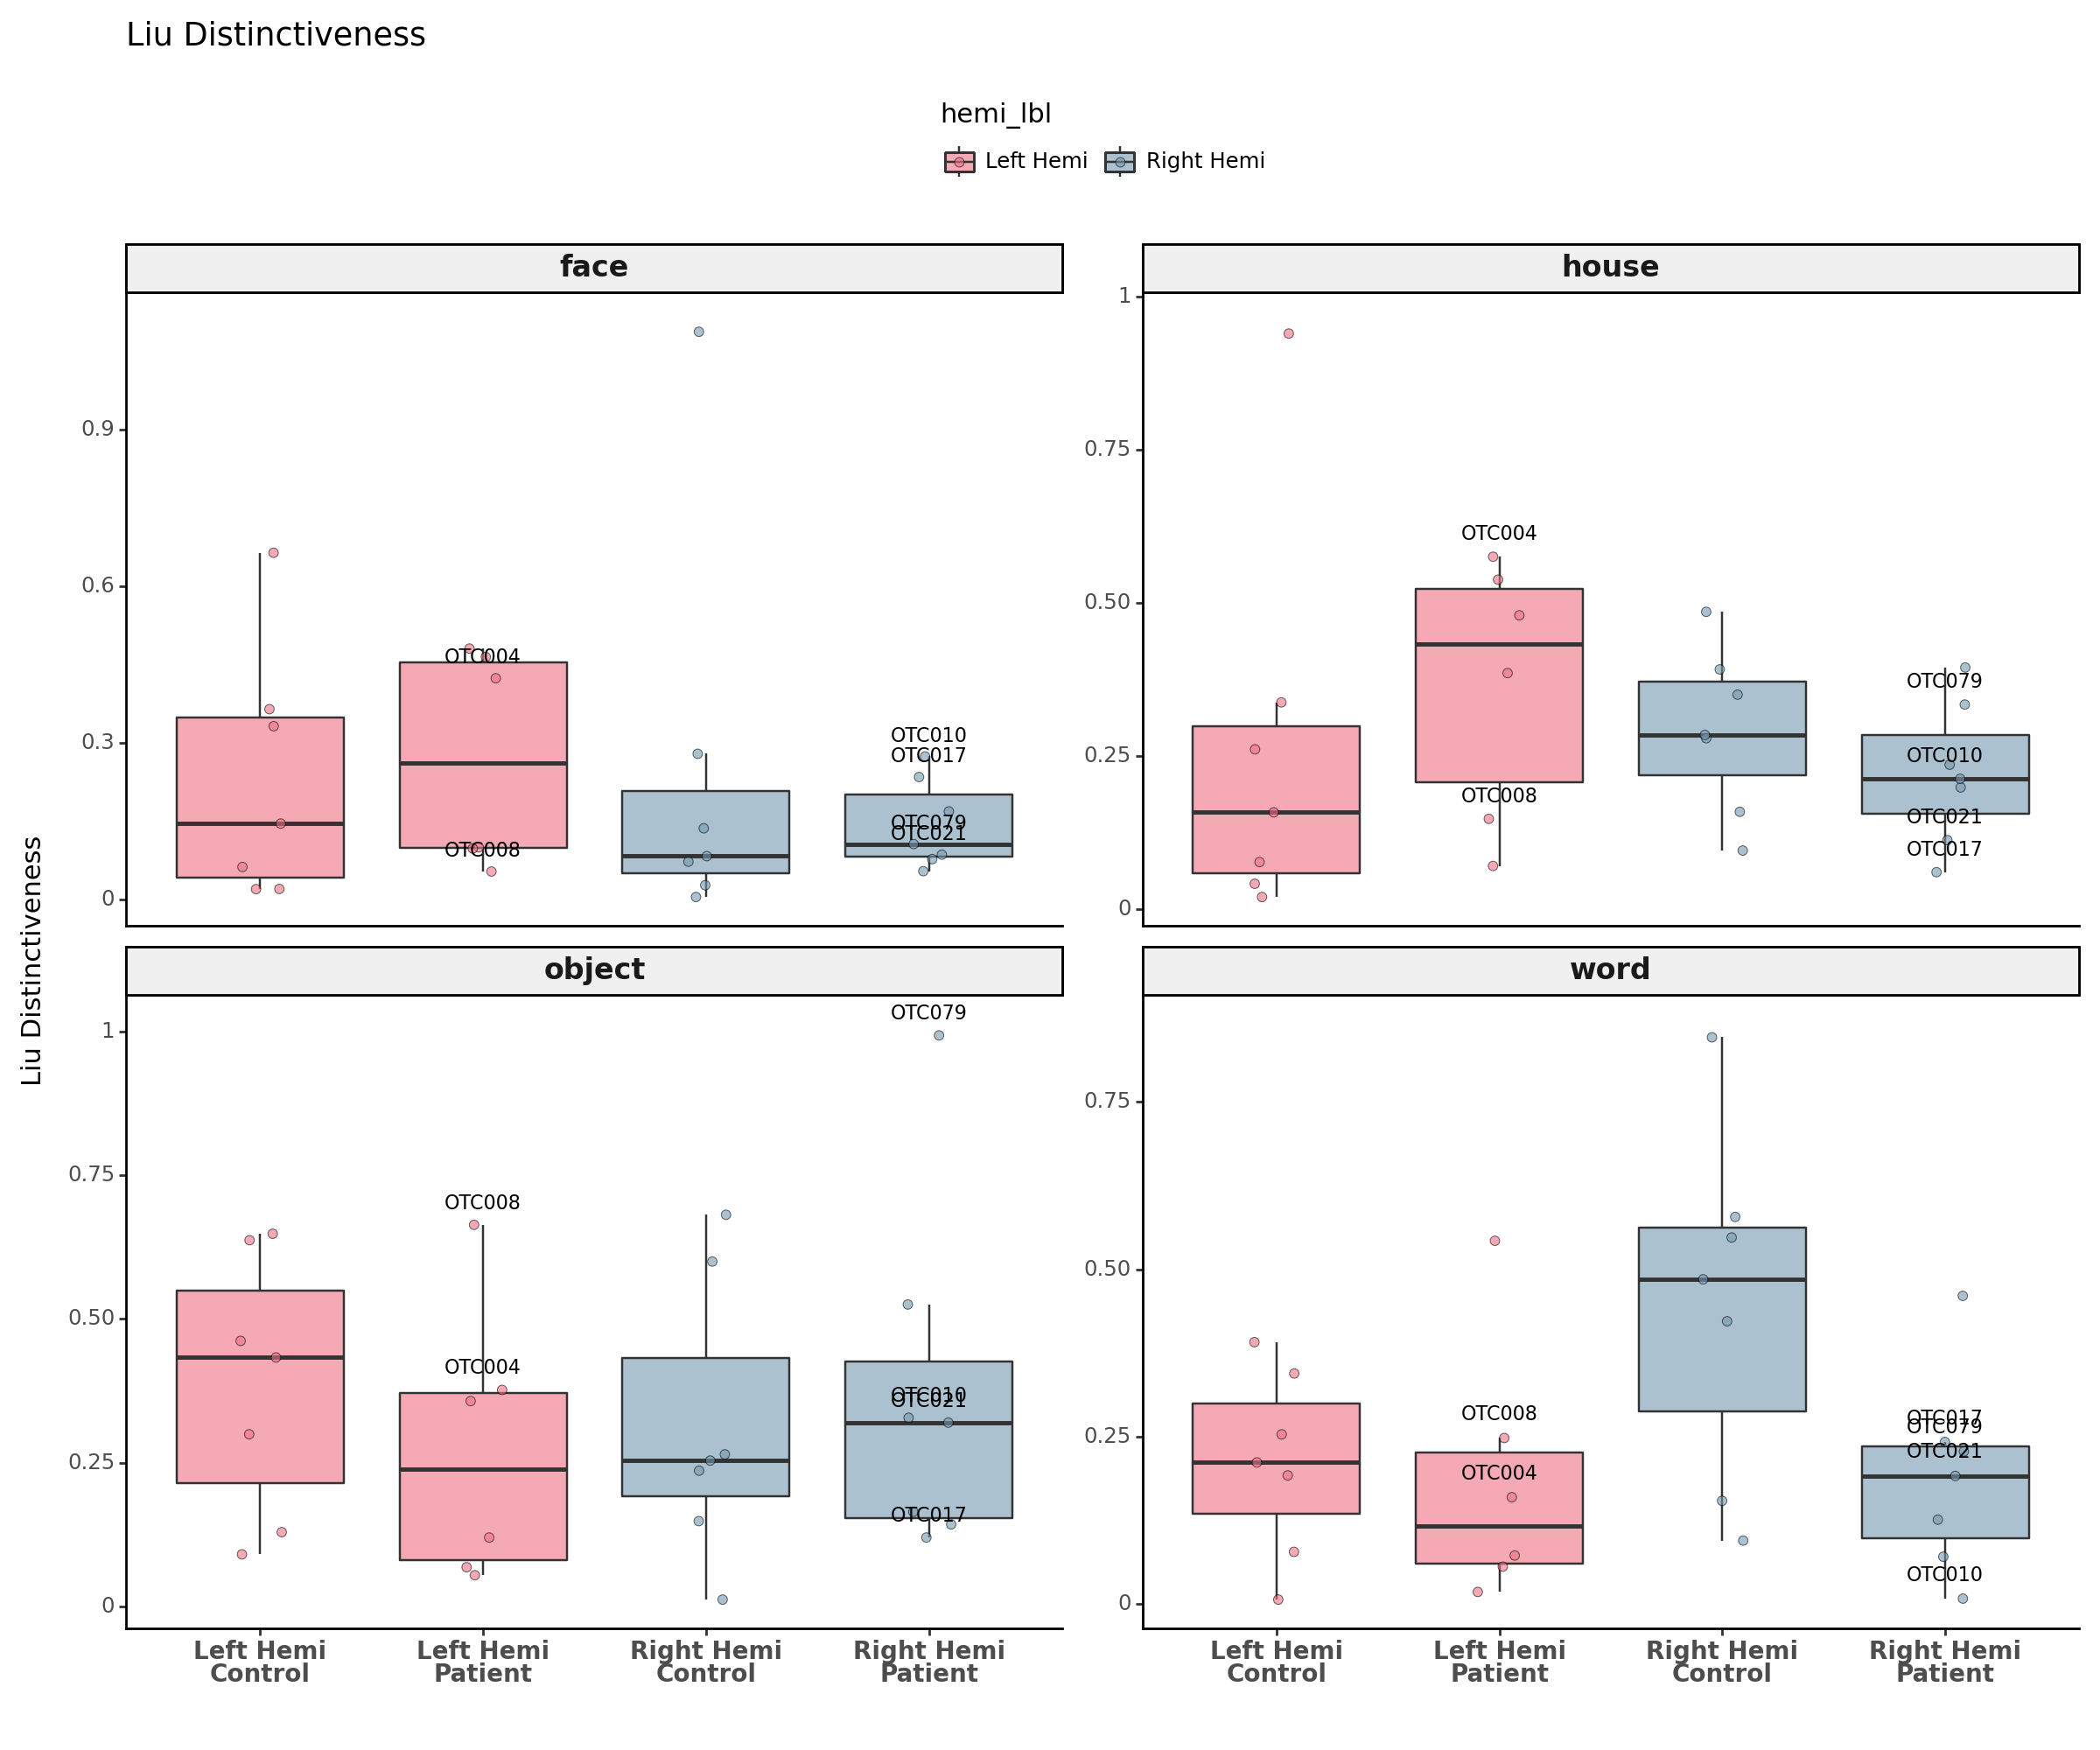

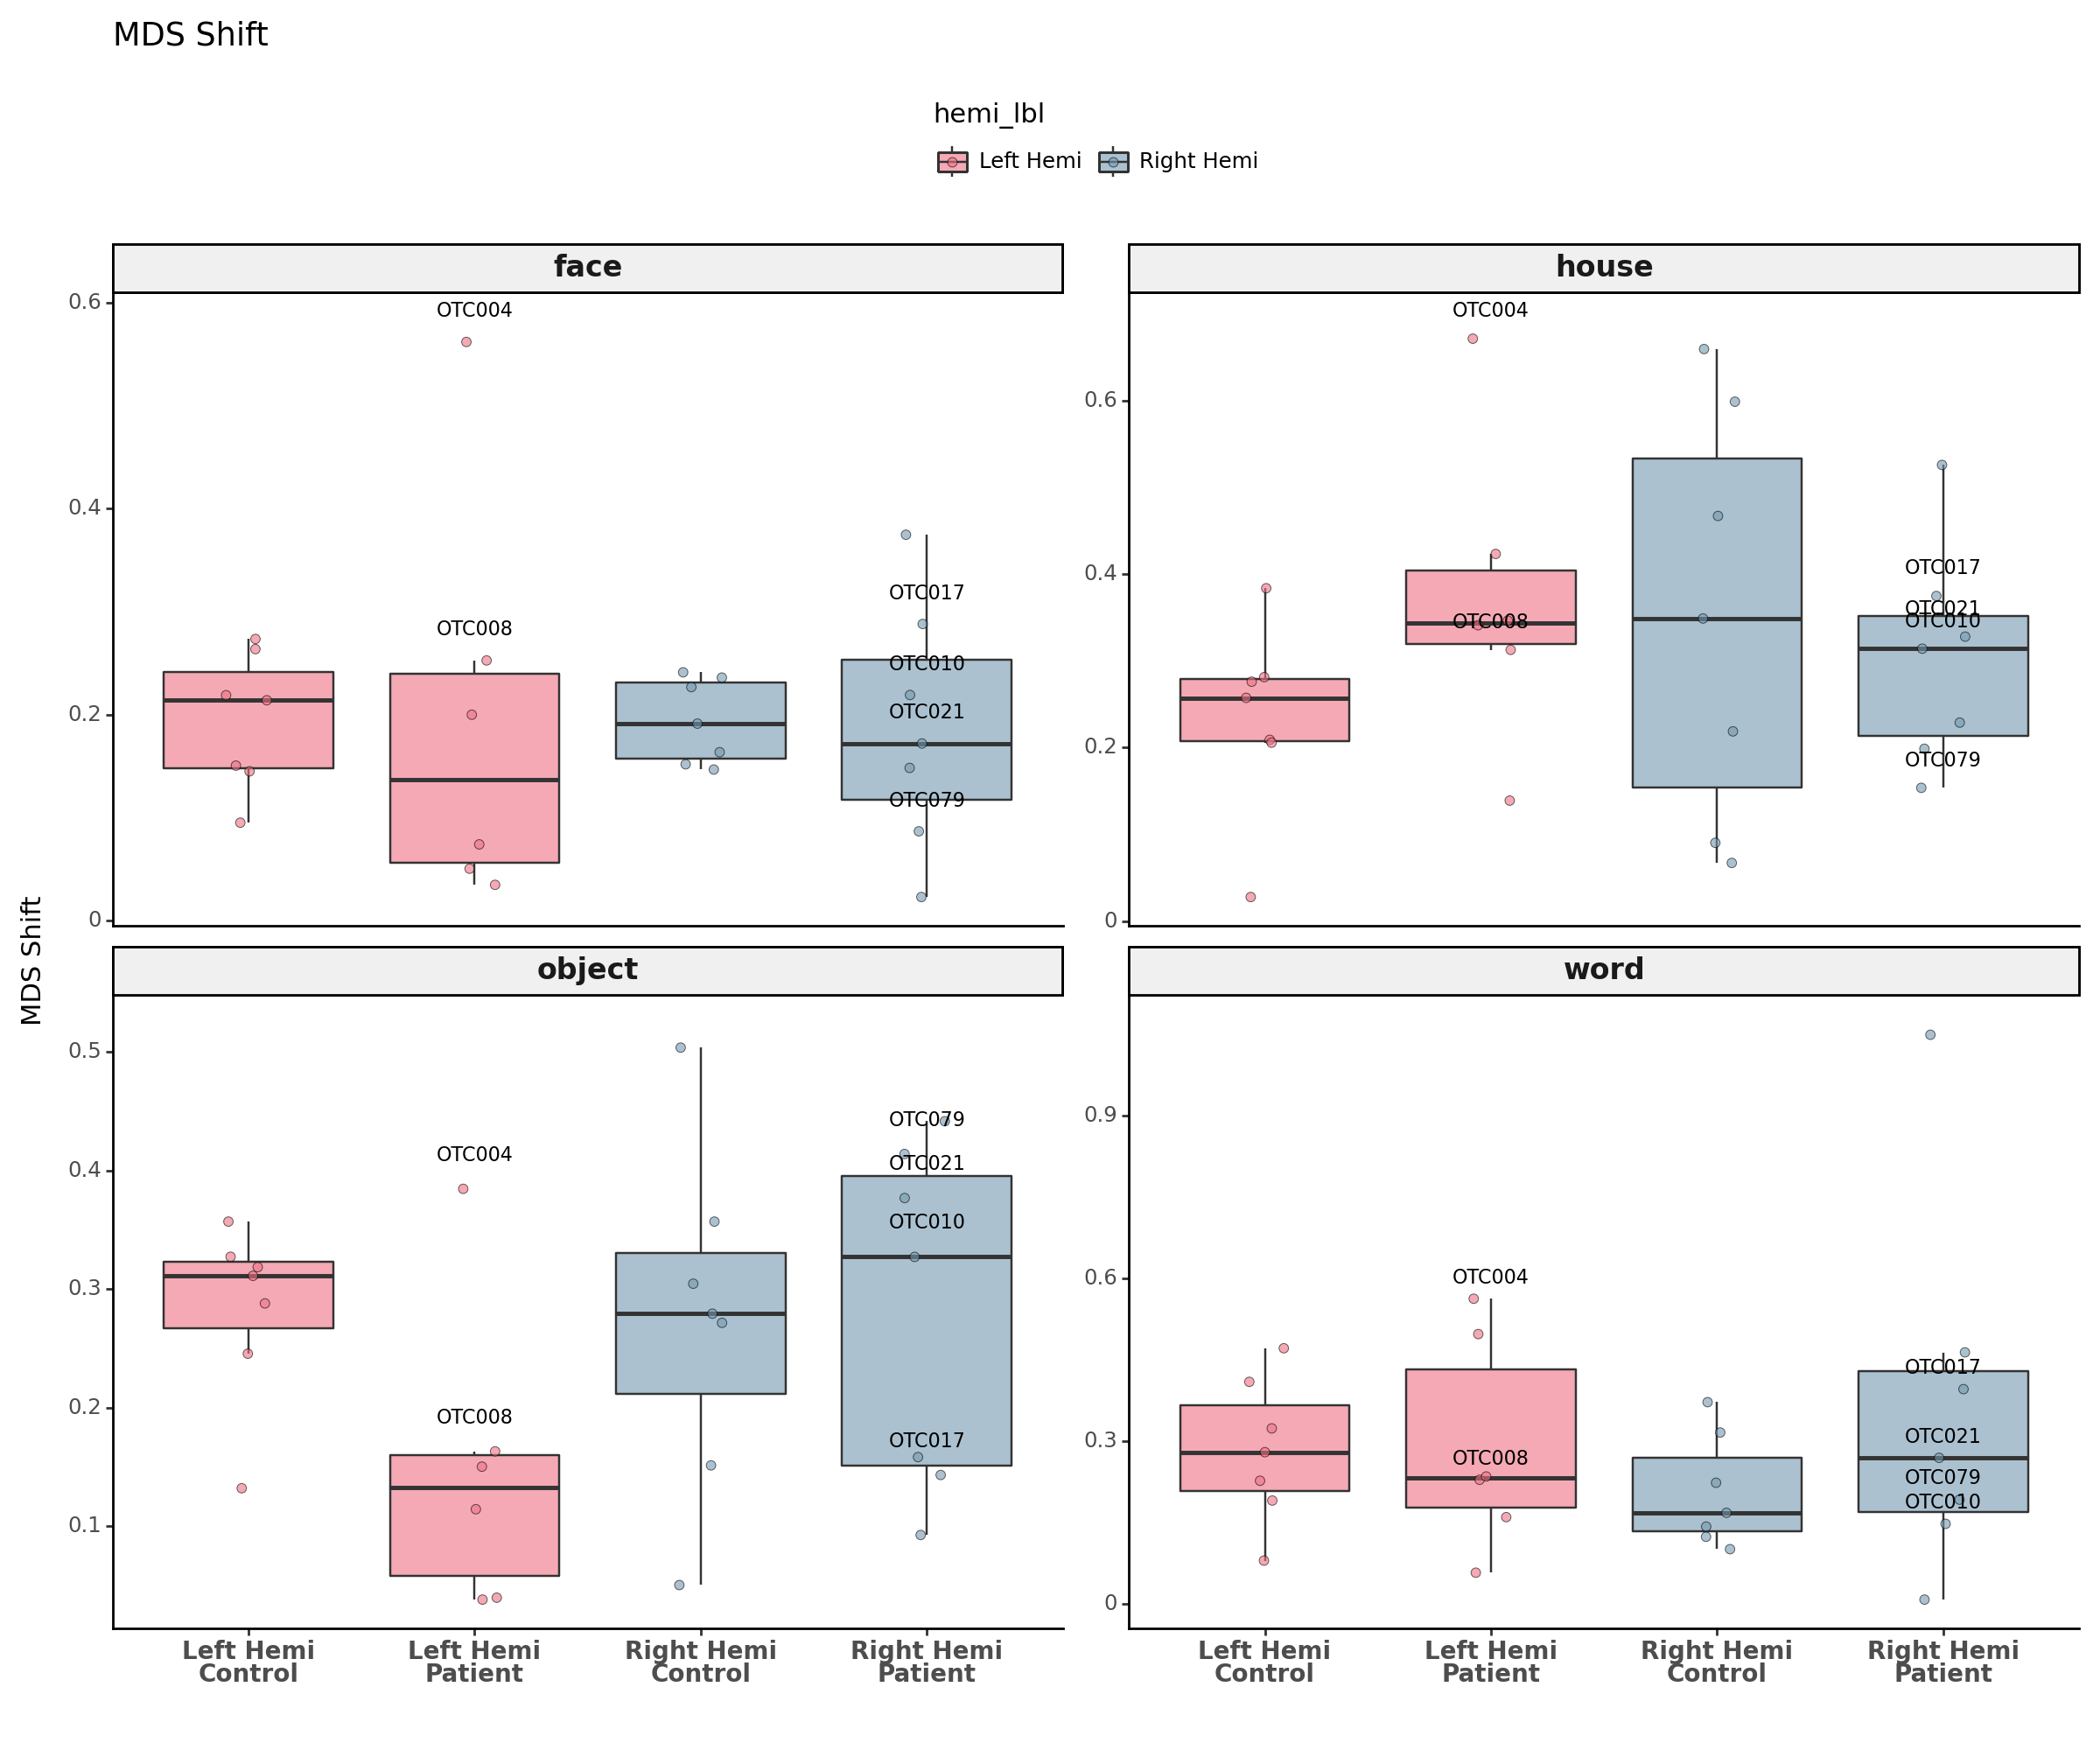

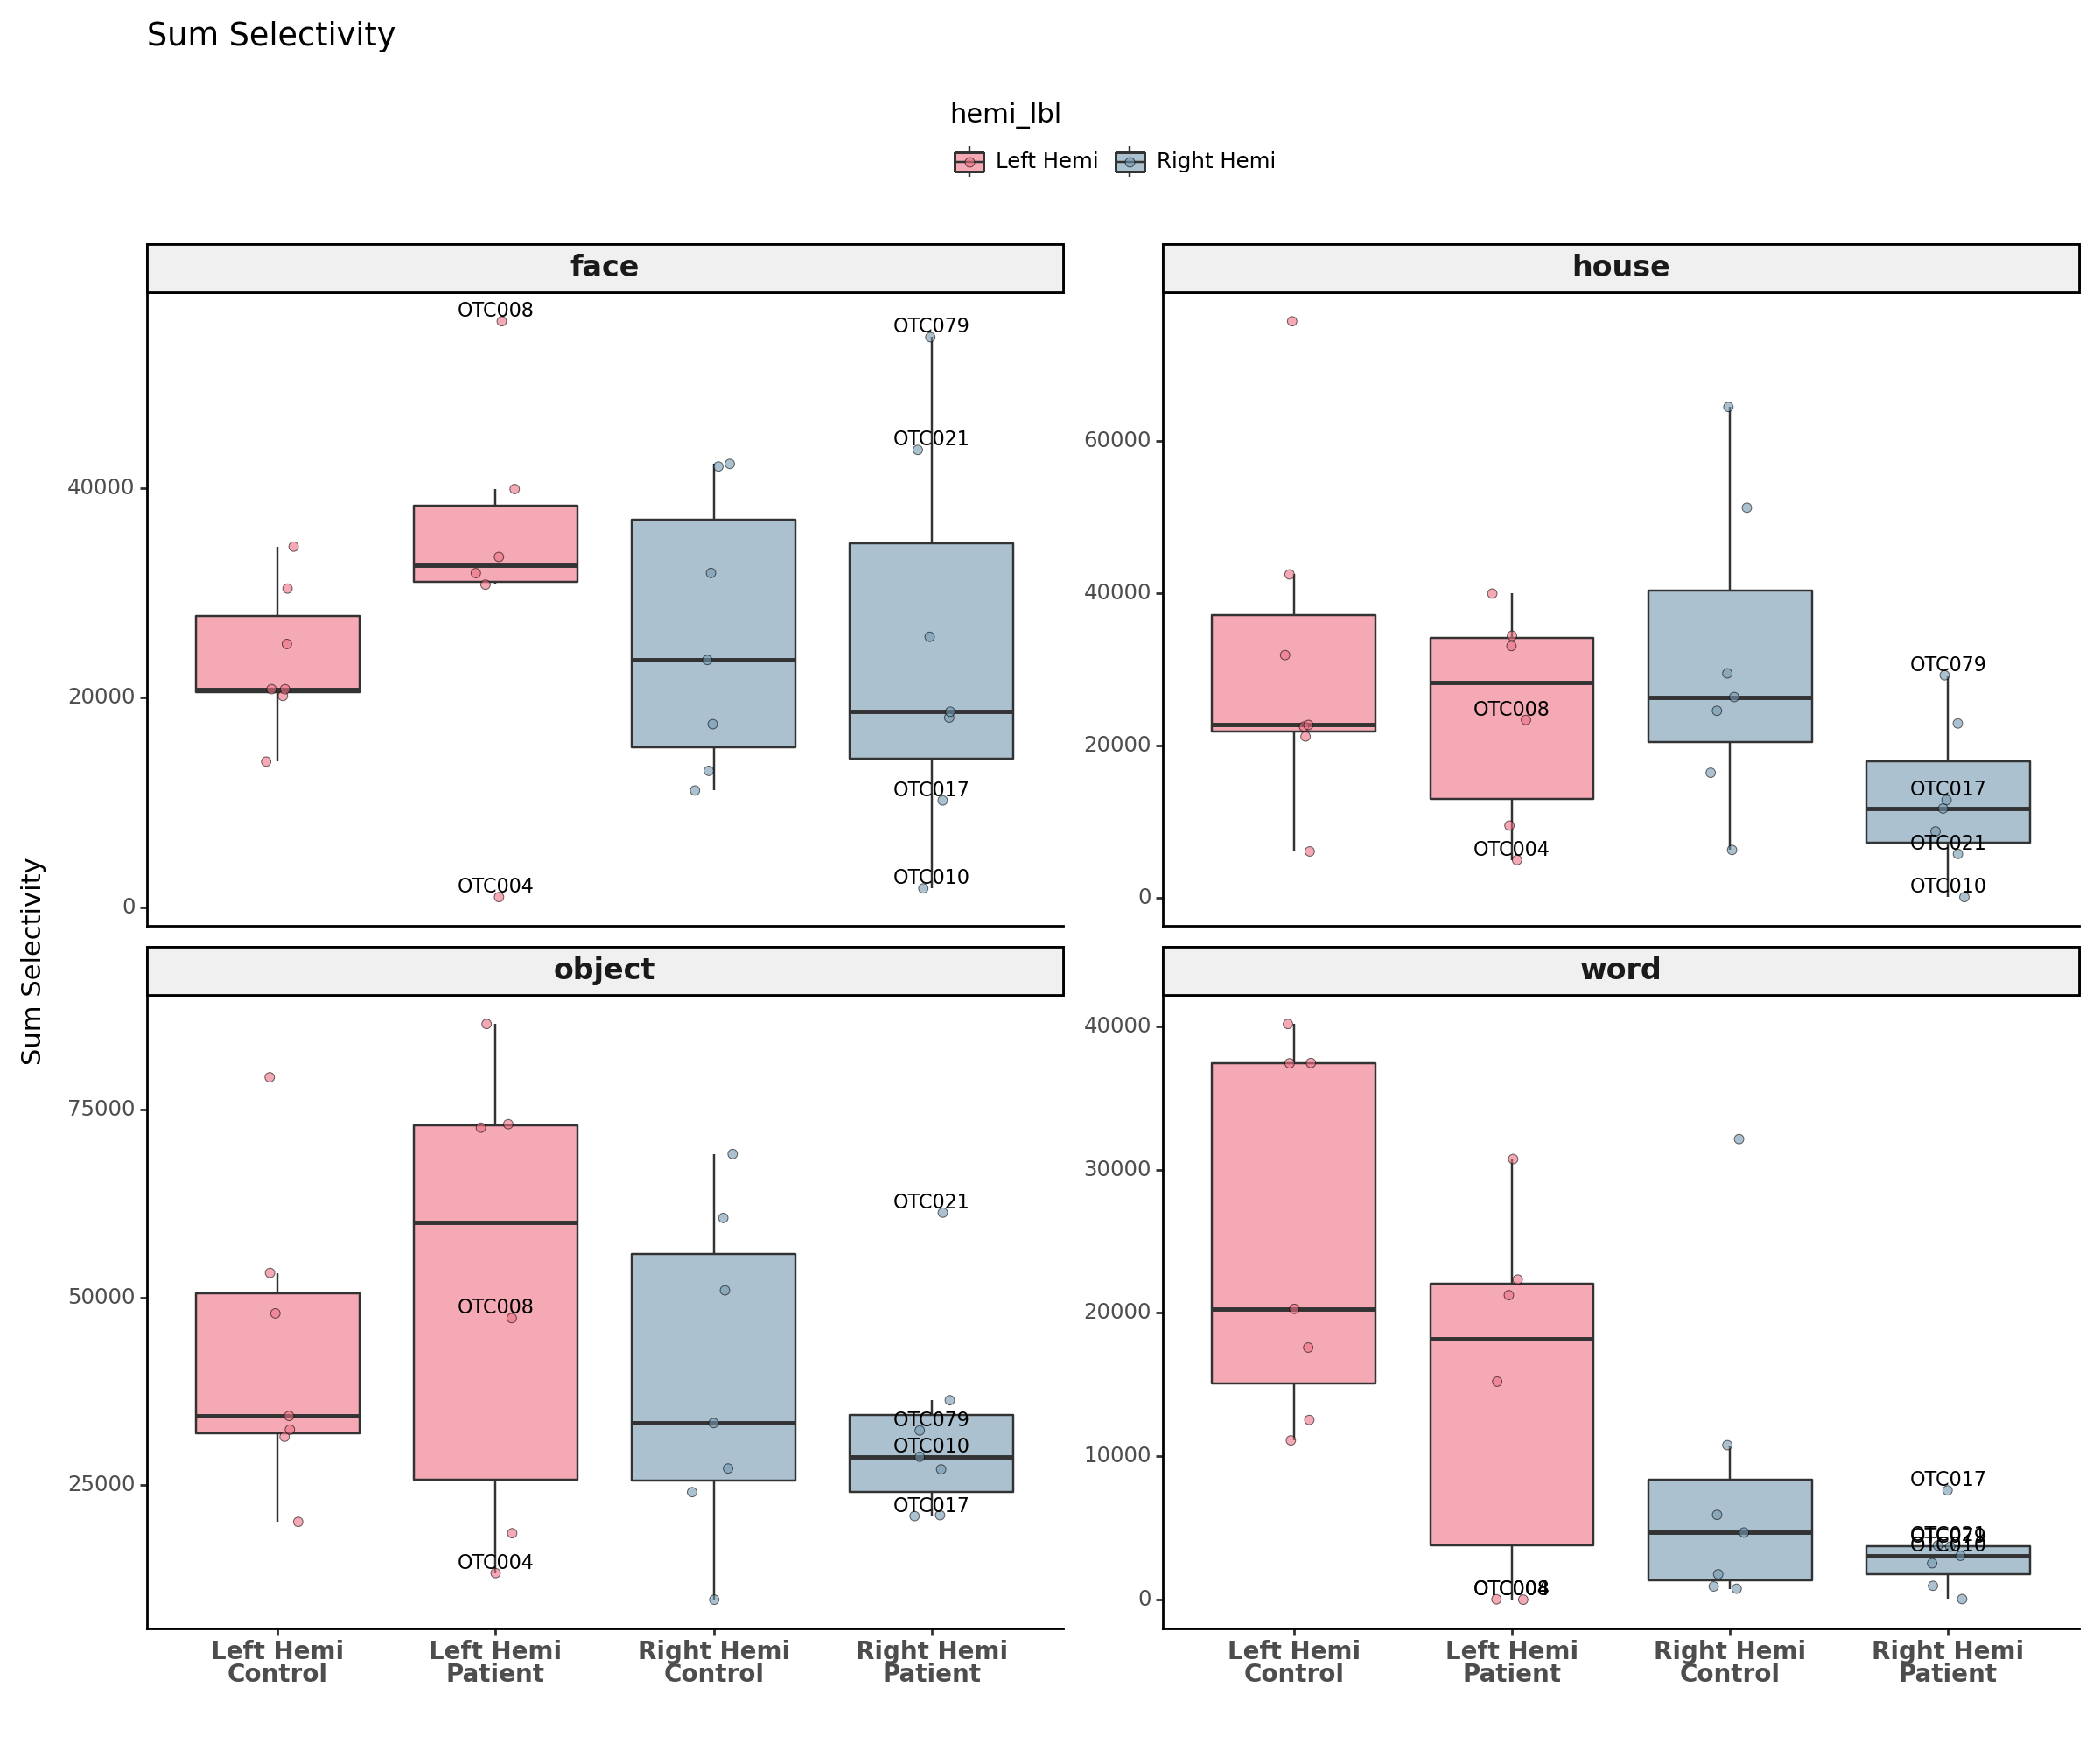

In [12]:
# =============================================================================
# CELL 10: REVISED VISUALIZATION (CORRECTED PATIENT DEFINITIONS)
# =============================================================================

from plotnine import *
import pandas as pd

print("\n" + "="*80)
print("VISUALIZATION: BOXPLOTS (Corrected: LH Pat = Preserved Left)")
print("="*80)

if 'all_scramble' not in all_results:
    print("Error: Please run the analysis cells above first.")
else:
    measures_to_plot = [
        ('liu', 'liu_distinctiveness', 'Liu Distinctiveness'),
        ('mds', 'mds_shift', 'MDS Shift'),
        ('sum_selectivity', 'sum_selectivity', 'Sum Selectivity'), 
    ]

    for source_key, col_name, title in measures_to_plot:
        if source_key not in all_results['all_scramble']: continue
            
        df = all_results['all_scramble'][source_key].copy()
        if 'roi_category' in df.columns: df = df.rename(columns={'roi_category': 'category'})

        # ---------------------------------------------------------
        # 1. DEFINE HEMISPHERE & GROUP LABELS
        # ---------------------------------------------------------
        df['hemi_lbl'] = df['hemi'].map({'l': 'Left Hemi', 'r': 'Right Hemi'})
        
        # Define Patient Type based on your rule:
        # If intact_hemi is Left -> "LH Patient" (Preserved Left)
        # We need to grab this from the subject info or infer it if not in df
        # (Assuming 'code' or 'group' contains this info, or using the CSV logic)
        
        def get_group_label(row):
            if row['group'] == 'control':
                return 'Control'
            
            # Use the subject code to determine patient type if possible
            # Logic: If code starts with 'L', it usually means LH Preserved in many datasets
            # BUT relying on your CSV 'intact_hemi' column is safer.
            # Since 'intact_hemi' isn't in this results df, we use the 'group' column 
            # assuming your CSV loader set group='OTC'. 
            
            # SIMPLIFIED PLOT LOGIC:
            # We just plot "Patient" vs "Control" per hemisphere.
            # The viewer (you) knows which patient is which type based on the label.
            return 'Patient'

        df['group_lbl'] = df.apply(get_group_label, axis=1)
        
        # ---------------------------------------------------------
        # 2. CREATE 4-GROUP SPLIT
        # ---------------------------------------------------------
        # We want: L-Hemi Control, L-Hemi Patient, R-Hemi Control, R-Hemi Patient
        df['four_groups'] = df['hemi_lbl'] + "\n" + df['group_lbl']
        
        # Force specific order on X-axis
        order = ['Left Hemi\nControl', 'Left Hemi\nPatient', 'Right Hemi\nControl', 'Right Hemi\nPatient']
        df['four_groups'] = pd.Categorical(df['four_groups'], categories=order, ordered=True)
        
        # ---------------------------------------------------------
        # 3. PATIENT LABELS
        # ---------------------------------------------------------
        # We label patients with their code (e.g. "L-018") so you can identify outlier/zero cases
        df['pat_label'] = df.apply(
            lambda x: x['code'] if x['group'] == 'OTC' else "", 
            axis=1
        )

        # ---------------------------------------------------------
        # 4. PLOTTING
        # ---------------------------------------------------------
        p = (ggplot(df, aes(x='four_groups', y=col_name, fill='hemi_lbl'))
             + geom_boxplot(alpha=0.6, outlier_shape='') 
             + geom_jitter(width=0.1, size=2, alpha=0.6, stroke=0.2)
             + geom_text(aes(label='pat_label'), va='bottom', size=8, nudge_y=0.02, color='black')
             
             + facet_wrap('~category', scales='free_y', ncol=2)
             + scale_fill_manual(values={'Left Hemi': '#ee7183', 'Right Hemi': '#7398af'})
             + labs(y=title, x="", title=f"{title}")
             + theme_classic()
             + theme(
                 figure_size=(12, 10),
                 axis_text_x=element_text(rotation=0, size=10, weight='bold'),
                 legend_position='top',
                 strip_background=element_rect(fill='#f0f0f0'),
                 strip_text=element_text(size=12, weight='bold')
             )
        )
        print(p)

In [15]:
# =============================================================================
# CELL 12: EXPORT DATA TO CSV
# =============================================================================

import pandas as pd

print("\n" + "="*80)
print("EXPORTING COMPREHENSIVE CSV")
print("="*80)

# List to hold all rows before making the final DataFrame
all_data = []

if not all_results:
    print("Error: No results found. Please run the analysis cells first.")
else:
    # We iterate through each contrast scheme (e.g., 'all_scramble', 'liu_mixed')
    for scheme_name, measures in all_results.items():
        
        # 1. Get the base dataframes
        df_liu = measures['liu'].copy()
        df_mds = measures['mds'].copy()
        df_sel = measures['sum_selectivity'].copy()
        
        # 2. Standardize column names
        if 'roi_category' in df_mds.columns: 
            df_mds = df_mds.rename(columns={'roi_category': 'category'})
        
        # 3. Merge them together
        # We start with Selectivity as the "base" because it has N_Voxels and Mean Act
        # Merge on: subject, hemi, category
        merge_cols = ['subject', 'hemi', 'category']
        
        # Merge Selectivity + Liu
        merged = pd.merge(df_sel, df_liu[merge_cols + ['liu_distinctiveness']], 
                          on=merge_cols, how='outer')
        
        # Merge + MDS
        # Note: MDS might have fewer rows if distinctiveness was too low to calculate RDM
        merged = pd.merge(merged, df_mds[merge_cols + ['mds_shift']], 
                          on=merge_cols, how='outer')
        
        # 4. Add Metadata
        merged['contrast_scheme'] = scheme_name
        
        # Define Patient Subgroup (LH vs RH Patient)
        def get_subgroup(row):
            if row['group'] == 'control': return 'Control'
            
            # Check the subject dictionary for the intact hemisphere
            sub_id = row['subject']
            if sub_id in ANALYSIS_SUBJECTS:
                intact = ANALYSIS_SUBJECTS[sub_id]['hemi']
                # If intact is Left (l), they are an LH Patient (Right Resected)
                # If intact is Right (r), they are an RH Patient (Left Resected)
                return 'LH_Patient_Preserved' if intact == 'l' else 'RH_Patient_Preserved'
            return 'Patient'

        merged['patient_subgroup'] = merged.apply(get_subgroup, axis=1)
        
        all_data.append(merged)

    # Combine everything
    final_df = pd.concat(all_data, ignore_index=True)

    # Reorder columns for readability
    cols = [
        'subject', 'code', 'group', 'patient_subgroup', 'hemi', 'category', 
        'contrast_scheme', 'n_voxels', 'sum_selectivity', 'mean_activation', 
        'liu_distinctiveness', 'mds_shift'
    ]
    # Keep only columns that actually exist in the dataframe
    final_cols = [c for c in cols if c in final_df.columns]
    final_df = final_df[final_cols]

    # Save to CSV
    csv_path = "comprehensive_results.csv"
    final_df.to_csv(csv_path, index=False)

    print(f"✓ Success! Generated {len(final_df)} rows of data.")
    print(f"✓ File saved as: {csv_path}")
    print("\nSample of the data:")
    print(final_df.head())

    # Optional: If you are mounting Drive, you can save a copy there too
    # drive_path = BASE_DIR / "comprehensive_results.csv"
    # final_df.to_csv(drive_path, index=False)
    # print(f"✓ Also saved to Drive at: {drive_path}")


EXPORTING COMPREHENSIVE CSV
✓ Success! Generated 432 rows of data.
✓ File saved as: comprehensive_results.csv

Sample of the data:
   subject       code   group      patient_subgroup hemi category  \
0  sub-004     OTC004     OTC  LH_Patient_Preserved    l     face   
1  sub-004     OTC004     OTC  LH_Patient_Preserved    l     word   
2  sub-004     OTC004     OTC  LH_Patient_Preserved    l   object   
3  sub-004     OTC004     OTC  LH_Patient_Preserved    l    house   
4  sub-007  nonOTC007  nonOTC  RH_Patient_Preserved    r     face   

  contrast_scheme  n_voxels  sum_selectivity  mean_activation  \
0       liu_mixed        49       121.493111         2.479451   
1       liu_mixed         3         7.635261         2.545087   
2       liu_mixed      3781     13307.628906         3.519606   
3       liu_mixed      2271      8154.509277         3.590713   
4       liu_mixed      2236      7679.120117         3.434311   

   liu_distinctiveness  mds_shift  
0             0.154039   0

Matched 320 rows between New and Reference data.

CORRELATION: New 'Liu Distinctiveness' vs Ref 'Selectivity Change'
------------------------------------------------------------
Scheme                    | R-Squared  | Correlation (r)
------------------------------------------------------------
liu_mixed                 | 0.0532     | 0.2306
all_scramble              | 0.0620     | 0.2489
all_vs_others             | 0.0016     | 0.0398
current_differential      | 0.0195     | 0.1397


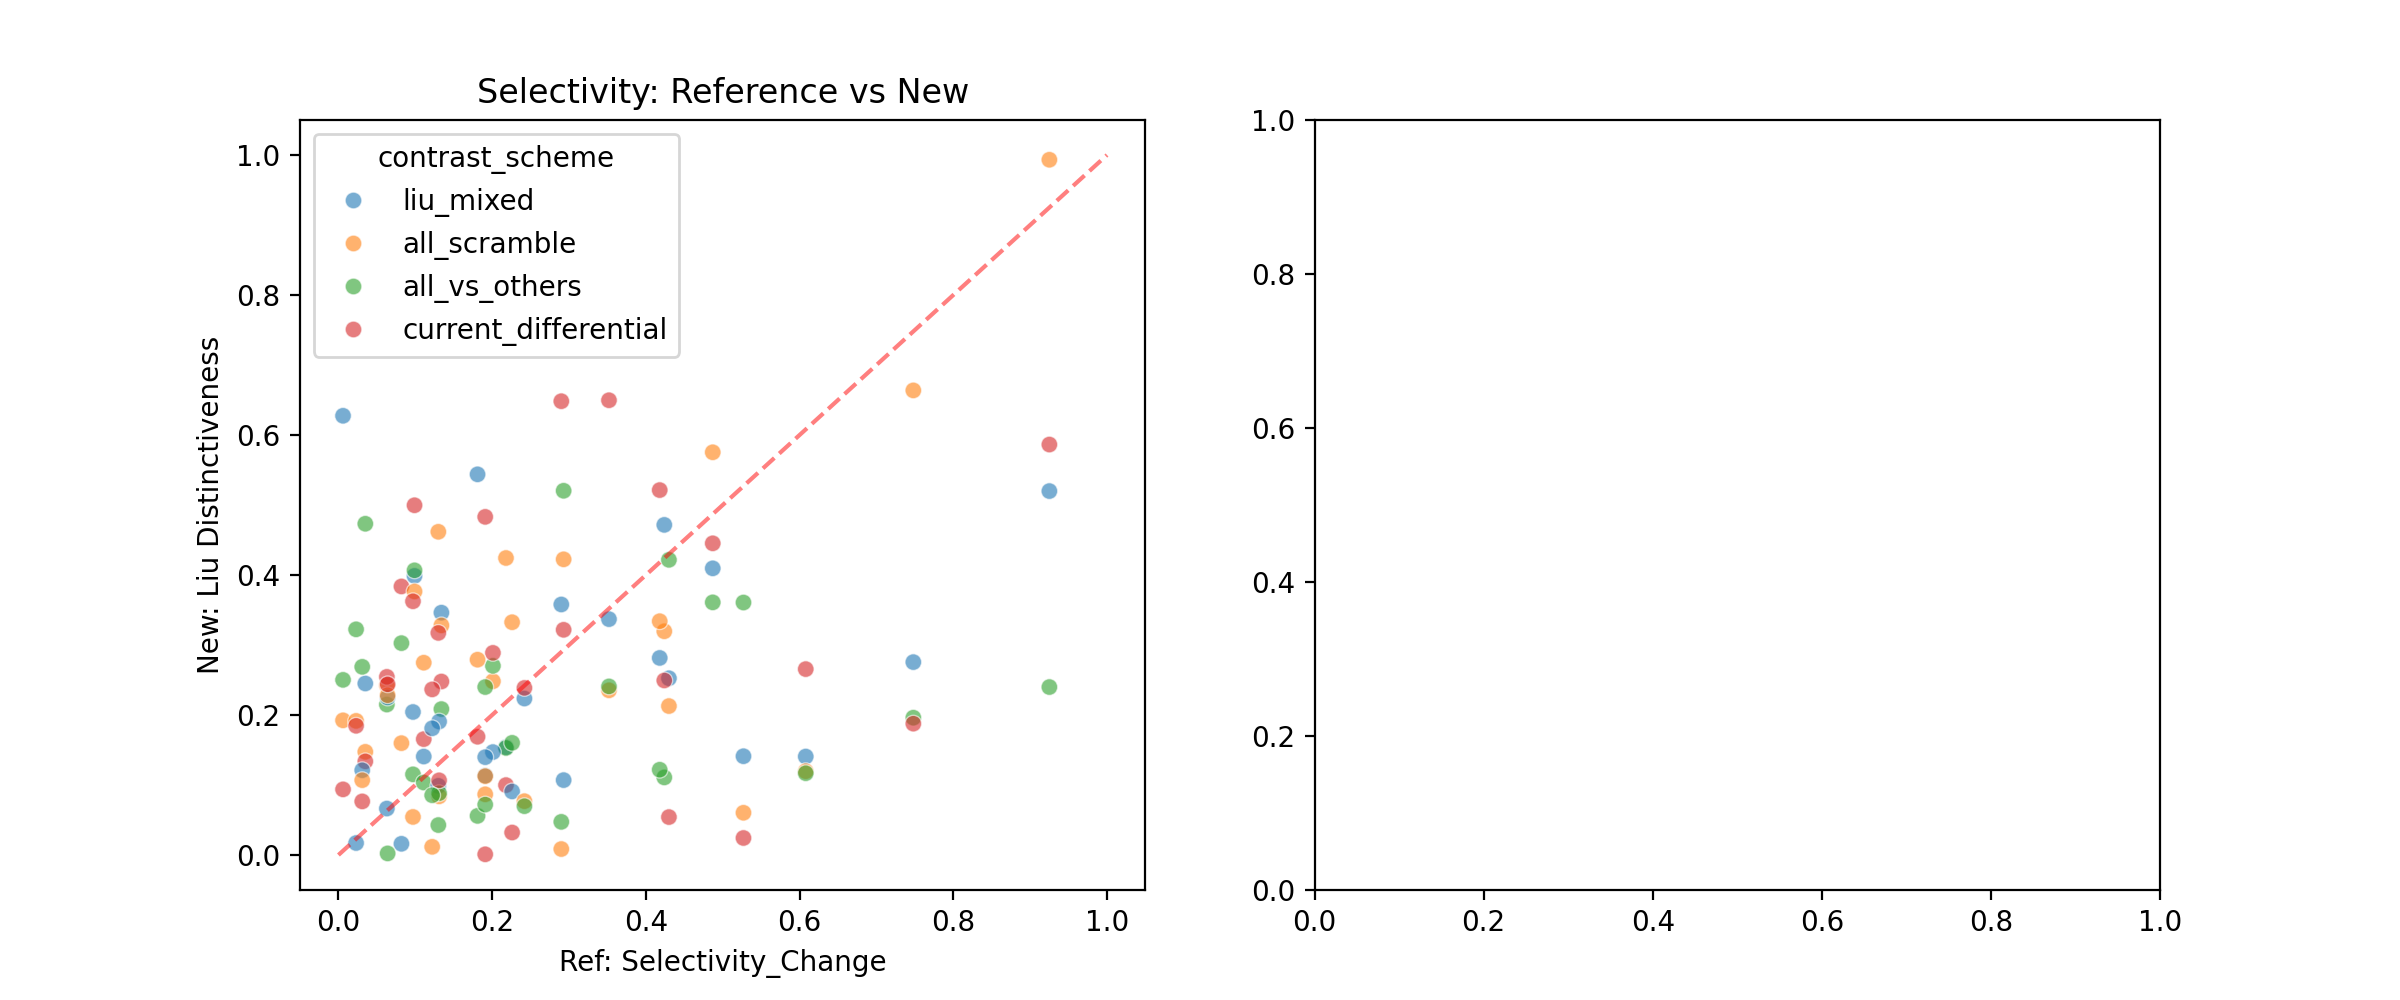

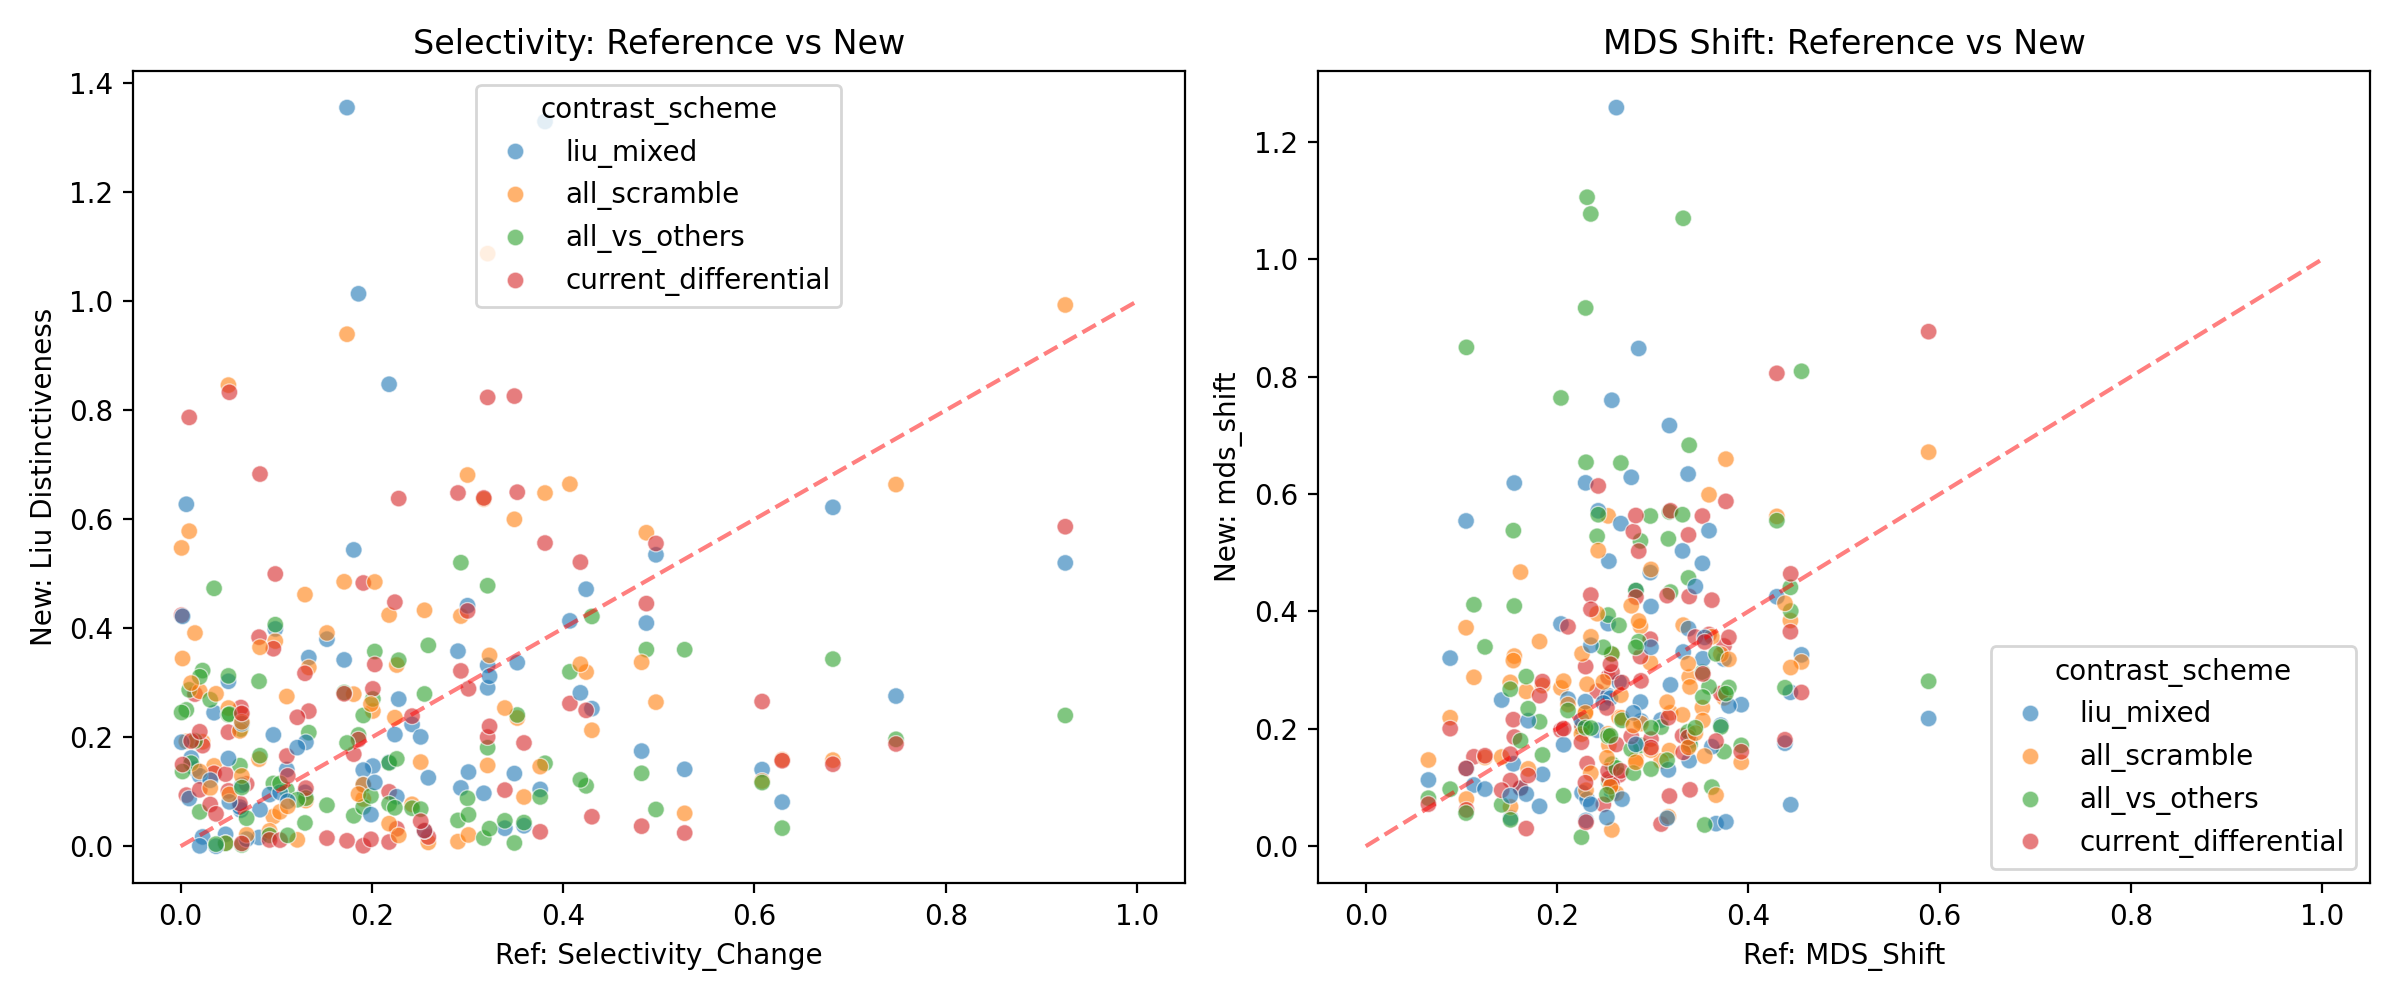

In [17]:
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# =============================================================================
# 1. LOAD THE DATA
# =============================================================================

# A. NEW RESULTS (From the notebook we just wrote)
new_csv_data = """subject,code,group,patient_subgroup,hemi,category,contrast_scheme,n_voxels,sum_selectivity,mean_activation,liu_distinctiveness,mds_shift
sub-004,OTC004,OTC,LH_Patient_Preserved,l,face,liu_mixed,49,121.49311065673828,2.4794511795043945,0.15403935527608761,0.42505008566442415
sub-004,OTC004,OTC,LH_Patient_Preserved,l,word,liu_mixed,3,7.635260581970215,2.5450868606567383,0.016026033588489974,0.37930878472490537
sub-004,OTC004,OTC,LH_Patient_Preserved,l,object,liu_mixed,3781,13307.62890625,3.5196056365966797,0.398731742051872,0.2621871338097426
sub-004,OTC004,OTC,LH_Patient_Preserved,l,house,liu_mixed,2271,8154.50927734375,3.5907130241394043,0.4094973388444726,0.21755459821593598
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,face,liu_mixed,2236,7679.1201171875,3.4343113899230957,0.038483644037356074,0.1863649938330659
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,word,liu_mixed,20,47.728370666503906,2.386418581008911,0.32560293790244343,0.5306986384618569
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,object,liu_mixed,6336,21022.2109375,3.317899465560913,0.1556433327554004,0.1123485930042843
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,house,liu_mixed,5865,20137.48046875,3.4335005283355713,0.1558066279772644,0.4263465211739196
sub-008,OTC008,OTC,LH_Patient_Preserved,l,face,liu_mixed,4535,21206.3359375,4.676148891448975,0.20430971925252006,0.3189279181184791
sub-008,OTC008,OTC,LH_Patient_Preserved,l,word,liu_mixed,13,31.55042839050293,2.4269559383392334,0.1470491109770607,0.6190985776860295
sub-008,OTC008,OTC,LH_Patient_Preserved,l,object,liu_mixed,9207,47268.83984375,5.134011268615723,0.2755348979680423,0.7167370114269509
sub-008,OTC008,OTC,LH_Patient_Preserved,l,house,liu_mixed,6283,27319.0859375,4.348095893859863,0.24500707567138666,0.4661965774892339
sub-010,OTC010,OTC,RH_Patient_Preserved,r,face,liu_mixed,82,233.4130859375,2.846501111984253,0.14067017925565023,0.27973987672654455
sub-010,OTC010,OTC,RH_Patient_Preserved,r,word,liu_mixed,999,3064.51513671875,3.067582607269287,0.3578866640263454,0.43568436701194946
sub-010,OTC010,OTC,RH_Patient_Preserved,r,object,liu_mixed,6847,28801.078125,4.206378936767578,0.34622347105875095,0.20617898470949028
sub-010,OTC010,OTC,RH_Patient_Preserved,r,house,liu_mixed,59,145.34628295898438,2.463496208190918,0.25248127877502285,0.32606440471767467
sub-017,OTC017,OTC,RH_Patient_Preserved,r,face,liu_mixed,1450,4606.185546875,3.1766796112060547,0.33691966661772643,0.1458684175252009
sub-017,OTC017,OTC,RH_Patient_Preserved,r,word,liu_mixed,2348,7625.28369140625,3.247565507888794,0.06636547630355907,0.19763980623188326
sub-017,OTC017,OTC,RH_Patient_Preserved,r,object,liu_mixed,4764,20897.6640625,4.386579513549805,0.14067481344921734,0.24116697509454052
sub-017,OTC017,OTC,RH_Patient_Preserved,r,house,liu_mixed,5517,19853.08203125,3.5985286235809326,0.14109035256685248,0.24559265451280216
sub-018,control018,control,Control,l,face,liu_mixed,2131,11356.7822265625,5.329320430755615,0.09078875735660036,0.21497460416841013
sub-018,control018,control,Control,l,word,liu_mixed,6790,40146.97265625,5.912661552429199,0.6274672497678755,0.27486359642921404
sub-018,control018,control,Control,l,object,liu_mixed,12306,79341.46875,6.447381019592285,0.09879148052871717,0.09058707905295772
sub-018,control018,control,Control,l,house,liu_mixed,6081,27222.15625,4.476592063903809,0.22351907530405474,0.2133948282127144
sub-018,control018,control,Control,r,face,liu_mixed,2630,13297.376953125,5.056036949157715,0.19066655972030516,0.4818910145620914
sub-018,control018,control,Control,r,word,liu_mixed,1360,4688.9658203125,3.4477689266204834,0.1069653670854689,0.5031263949868314
sub-018,control018,control,Control,r,object,liu_mixed,10935,69121.71875,6.321145057678223,0.1810171967353265,0.17966848741347116
sub-018,control018,control,Control,r,house,liu_mixed,7403,40358.65234375,5.451661586761475,0.5437863230467564,0.5376287009578207
sub-021,OTC021,OTC,RH_Patient_Preserved,r,face,liu_mixed,2056,10800.419921875,5.253122329711914,0.1397357424551545,0.48563003465568505
sub-021,OTC021,OTC,RH_Patient_Preserved,r,word,liu_mixed,1089,3788.91162109375,3.479257583618164,0.01710008555110236,0.3787083879603737
sub-021,OTC021,OTC,RH_Patient_Preserved,r,object,liu_mixed,13186,61313.3046875,4.649878978729248,0.47159776230847206,0.33091657938303737
sub-021,OTC021,OTC,RH_Patient_Preserved,r,house,liu_mixed,5534,19452.796875,3.5151422023773193,0.11327940443163387,0.0911957416662599
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,face,liu_mixed,2457,15740.6064453125,6.40643310546875,0.0027400693439124657,0.2653202559930077
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,word,liu_mixed,3847,21236.8515625,5.52036714553833,0.00011007488790171216,0.08578684437835125
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,object,liu_mixed,11504,72630.0859375,6.3134636878967285,0.029331872325670583,0.07957499901085581
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,house,liu_mixed,8214,62967.03125,7.665818214416504,0.1067004841596656,0.07203909803305075
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,face,liu_mixed,2319,13998.3251953125,6.036362648010254,0.13777014341655763,0.04024329660718629
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,word,liu_mixed,2851,22328.609375,7.831851959228516,0.036253448355754274,0.048209370319278466
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,object,liu_mixed,8431,73095.453125,8.669843673706055,0.031194321630095834,0.08266560994336873
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,house,liu_mixed,7700,48747.62890625,6.3308610916137695,0.37292102604504573,0.37135908474932244
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,face,liu_mixed,2935,16802.08984375,5.724732398986816,0.2366723513619698,0.056400520284971806
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,word,liu_mixed,803,2545.11083984375,3.1695029735565186,0.06162122878932738,0.10721295217831851
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,object,liu_mixed,6031,27125.921875,4.497748374938965,0.09408736339189089,0.15246291566633452
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,house,liu_mixed,4641,26289.263671875,5.664568901062012,0.025687913610211888,0.07335767881749447
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,face,liu_mixed,1327,6760.70654296875,5.094729900360107,0.0027706481529696236,0.35782965846173675
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,word,liu_mixed,5847,30728.65234375,5.25545597076416,0.031231671240765674,0.05510453528235853
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,object,liu_mixed,11988,86438.59375,7.2104268074035645,0.2718978609011645,0.014458125850617247
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,house,liu_mixed,5011,24740.80078125,4.93729829788208,0.3850104479768993,0.3625946294924887
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,face,liu_mixed,2544,15592.5625,6.129151821136475,0.10217761305191017,0.25842098569555916
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,word,liu_mixed,301,974.2650146484375,3.2367608547210693,0.4688945583448597,0.8614191025147503
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,object,liu_mixed,6232,36333.13671875,5.830092430114746,0.23199293835832002,0.24391984578015186
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,house,liu_mixed,1447,7519.3056640625,5.196479320526123,0.22589028305643183,0.2328585338551834
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,face,liu_mixed,3145,21967.2421875,6.984814643859863,0.02577331659838724,0.055333248884593025
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,word,liu_mixed,3811,15208.7021484375,3.9907379150390625,0.4021091524593818,0.37815104148750417
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,object,liu_mixed,4515,18616.73046875,4.123306751251221,0.2391821228704137,0.08604457429951796
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,house,liu_mixed,2277,8965.724609375,3.937516212463379,0.09363053242790445,0.19091949295904947
sub-022,control022,control,Control,l,face,liu_mixed,1220,4921.8095703125,4.034270286560059,0.06711438190913906,0.12234749103596342
sub-022,control022,control,Control,l,word,liu_mixed,4707,20278.78515625,4.308218479156494,0.14160302713797726,0.6188008052998895
sub-022,control022,control,Control,l,object,liu_mixed,4375,20131.328125,4.601446628570557,0.03766184832319586,0.10431542403529209
sub-022,control022,control,Control,l,house,liu_mixed,5819,23672.263671875,4.068098068237305,0.8476962695479305,0.7597703191301212
sub-022,control022,control,Control,r,face,liu_mixed,845,3052.97314453125,3.6129860877990723,0.09482030907509209,0.2567195013528915
sub-022,control022,control,Control,r,word,liu_mixed,642,1776.47216796875,2.7670905590057373,0.19083412400109728,0.1404027257380716
sub-022,control022,control,Control,r,object,liu_mixed,2536,9770.431640625,3.852693796157837,0.5347974252465302,0.5715235786006304
sub-022,control022,control,Control,r,house,liu_mixed,7298,28899.65625,3.959941864013672,1.0137623587014772,1.258405861809626
sub-052,control052,control,Control,l,face,liu_mixed,1839,6775.7919921875,3.6844980716705322,0.4135682139876153,0.3193275838855431
sub-052,control052,control,Control,l,word,liu_mixed,7577,37406.2109375,4.93681001663208,0.1256499240985568,0.40843664893301707
sub-052,control052,control,Control,l,object,liu_mixed,10974,53284.82421875,4.855551719665527,1.3298555439822295,0.6341039893706746
sub-052,control052,control,Control,l,house,liu_mixed,6905,30663.33203125,4.440743446350098,1.3554094742558203,0.8480148251947958
sub-052,control052,control,Control,r,face,liu_mixed,1571,5401.60400390625,3.438322067260742,0.3319370743906997,0.339047553276415953
sub-052,control052,control,Control,r,word,liu_mixed,8434,32125.16796875,3.809007406234741,0.30258393127321925,0.37072734291972376
sub-052,control052,control,Control,r,object,liu_mixed,11684,60608.234375,5.187284469604492,0.4414200080719032,0.07073365245450737
sub-052,control052,control,Control,r,house,liu_mixed,4700,20580.234375,4.378773212432861,0.3799169621448648,0.09878154750301515
sub-058,control058,control,Control,l,face,liu_mixed,1127,4340.95751953125,3.8517813682556152,0.09873632246258573,0.08883247720360501
sub-058,control058,control,Control,l,word,liu_mixed,3305,17584.404296875,5.3205461502075195,0.033048623207421135,0.21529166651268472
sub-058,control058,control,Control,l,object,liu_mixed,7297,47895.4296875,6.563714981079102,0.027931704096268883,0.16950757026876892
sub-058,control058,control,Control,l,house,liu_mixed,2283,11125.109375,4.873022079467773,0.17455864294277434,0.08010004610074008
sub-058,control058,control,Control,r,face,liu_mixed,410,1319.76806640625,3.2189464569091797,0.08253689886683696,0.2506294563263324
sub-058,control058,control,Control,r,word,liu_mixed,323,928.407958984375,2.874328136444092,0.0875917991832032,0.25225123958571527
sub-058,control058,control,Control,r,object,liu_mixed,7199,33292.9140625,4.624658107757568,0.2907710043454493,0.13010591580702133
sub-058,control058,control,Control,r,house,liu_mixed,2914,12457.6396484375,4.275099277496338,0.12924146175589485,0.06796509782479027
sub-062,control062,control,Control,l,face,liu_mixed,509,1872.6768798828125,3.6791293621063232,0.13607046856566937,0.3204455605105666
sub-062,control062,control,Control,l,word,liu_mixed,3039,12540.22265625,4.126430511474609,0.07188153722438824,0.13228539334521286
sub-062,control062,control,Control,l,object,liu_mixed,6004,31464.47265625,5.240584850311279,0.16191210541329965,0.21390345389422477
sub-062,control062,control,Control,l,house,liu_mixed,6320,30778.71484375,4.870049953460693,0.058025968485338086,0.17296972354860793
sub-062,control062,control,Control,r,face,liu_mixed,2139,10546.42578125,4.930540561676025,0.021822452420873897,0.11286363889080836
sub-062,control062,control,Control,r,word,liu_mixed,273,767.1817626953125,2.810189723968506,0.20064118366276978,0.5541861350071974
sub-062,control062,control,Control,r,object,liu_mixed,5247,24089.93359375,4.591182231903076,0.1610423349953322,0.09738339102806087
sub-062,control062,control,Control,r,house,liu_mixed,6782,37141.1171875,5.476425647735596,0.08104761029030838,0.0482104779944447
sub-064,control064,control,Control,l,face,liu_mixed,1099,3759.36767578125,3.4207167625427246,0.10424861493235749,0.04398063841013105
sub-064,control064,control,Control,l,word,liu_mixed,2596,11110.5849609375,4.279886245727539,0.2072671663283128,0.2440691824942349
sub-064,control064,control,Control,l,object,liu_mixed,6832,32417.837890625,4.744999885559082,0.09715239920685348,0.047524095467724
sub-064,control064,control,Control,l,house,liu_mixed,5940,30498.57421875,5.134439945220947,0.6218796550450955,0.5496642958671438
sub-064,control064,control,Control,r,face,liu_mixed,1296,4975.0263671875,3.838754892349243,0.0007053261852952852,0.249073598002325
sub-064,control064,control,Control,r,word,liu_mixed,1440,5918.482421875,4.110057353973389,0.08140009719439123,0.07146965486535474
sub-064,control064,control,Control,r,object,liu_mixed,6262,27239.87890625,4.3500285148620605,0.2049070408072144,0.08598394041424418
sub-064,control064,control,Control,r,house,liu_mixed,6947,32999.0625,4.75011682510376,0.34194707354526366,0.08018076442146684
sub-079,OTC079,OTC,RH_Patient_Preserved,r,face,liu_mixed,5166,29756.990234375,5.76016092300415,0.12108792141617991,0.038532105822948574
sub-079,OTC079,OTC,RH_Patient_Preserved,r,word,liu_mixed,1096,3701.80908203125,3.377562999725342,0.22506299294933796,0.4424899553849149
sub-079,OTC079,OTC,RH_Patient_Preserved,r,object,liu_mixed,6127,32302.54296875,5.272162914276123,0.5198788658897833,0.17549010544755067
sub-079,OTC079,OTC,RH_Patient_Preserved,r,house,liu_mixed,5100,25449.078125,4.990015506744385,0.2815336588239344,0.35572496768508943
sub-068,control068,control,Control,l,face,liu_mixed,3112,14760.837890625,4.743199825286865,0.012936590969179984,0.04886782738733966
sub-068,control068,control,Control,l,word,liu_mixed,6314,37429.5390625,5.928023338317871,0.421865805443543,0.6285166740917812
sub-068,control068,control,Control,l,object,liu_mixed,7161,34235.375,4.78080940246582,0.11211575966848075,0.23914547376304177
sub-068,control068,control,Control,l,house,liu_mixed,5479,23291.38671875,4.251029014587402,0.26989542188004895,0.22722709091965584
sub-068,control068,control,Control,r,face,liu_mixed,3038,13969.666015625,4.5983099937438965,6.513908424859993e-05,0.24634066313223607
sub-068,control068,control,Control,r,word,liu_mixed,2720,10777.853515625,3.9624462127685547,0.11705181017128241,0.17350564305305022
sub-068,control068,control,Control,r,object,liu_mixed,9851,50967.17578125,5.173807144165039,0.1333747176933402,0.34233457238200665
sub-068,control068,control,Control,r,house,liu_mixed,4698,19468.2890625,4.143952369689941,0.3119817828405698,0.04152206009639477
sub-004,OTC004,OTC,LH_Patient_Preserved,l,face,all_scramble,376,1008.674560546875,2.682645082473755,0.42428433821617323,0.5619344226910333
sub-004,OTC004,OTC,LH_Patient_Preserved,l,word,all_scramble,3,7.635260581970215,2.5450868606567383,0.159765818391444,0.5628048442179638
sub-004,OTC004,OTC,LH_Patient_Preserved,l,object,all_scramble,3781,13307.62890625,3.5196056365966797,0.3764490279605911,0.3844711680567827
sub-004,OTC004,OTC,LH_Patient_Preserved,l,house,all_scramble,1671,5012.3779296875,2.9996278285980225,0.5752932529451809,0.6713957559931826
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,face,all_scramble,4215,18116.375,4.298072338104248,0.16949190306324358,0.14849218543736675
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,word,all_scramble,20,47.728370666503906,2.386418581008911,0.1262927015855967,0.46402757506761827
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,object,all_scramble,6336,21022.2109375,3.317899465560913,0.14247916088964985,0.15810699628442834
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,house,all_scramble,3204,11767.748046875,3.67283034324646,0.19870187880205772,0.5258454517456561
sub-008,OTC008,OTC,LH_Patient_Preserved,l,face,all_scramble,8738,55883.15625,6.395417213439941,0.0543669962178116,0.2528179244656082
sub-008,OTC008,OTC,LH_Patient_Preserved,l,word,all_scramble,13,31.55042839050293,2.4269559383392334,0.24816273711205453,0.22930046777203203
sub-008,OTC008,OTC,LH_Patient_Preserved,l,object,all_scramble,9207,47268.83984375,5.134011268615723,0.6636917288766504,0.1629420915349679
sub-008,OTC008,OTC,LH_Patient_Preserved,l,house,all_scramble,6953,23376.04296875,3.3620080947875977,0.1473946743749625,0.3126690038408533
sub-010,OTC010,OTC,RH_Patient_Preserved,r,face,all_scramble,580,1832.7110595703125,3.159846544265747,0.2747199079167745,0.21928886753918714
sub-010,OTC010,OTC,RH_Patient_Preserved,r,word,all_scramble,999,3064.51513671875,3.067582607269287,0.00850537643614685,0.14811302630698367
sub-010,OTC010,OTC,RH_Patient_Preserved,r,object,all_scramble,6847,28801.078125,4.206378936767578,0.32802014770486904,0.32702885794083364
sub-010,OTC010,OTC,RH_Patient_Preserved,r,house,all_scramble,57,154.10597229003906,2.703613519668579,0.21276157861170752,0.3140072921931331
sub-017,OTC017,OTC,RH_Patient_Preserved,r,face,all_scramble,2781,10224.03515625,3.6763880252838135,0.23525920012870494,0.28817556076703427
sub-017,OTC017,OTC,RH_Patient_Preserved,r,word,all_scramble,2348,7625.28369140625,3.247565507888794,0.2423048109274955,0.39622361204628037
sub-017,OTC017,OTC,RH_Patient_Preserved,r,object,all_scramble,4764,20897.6640625,4.386579513549805,0.11970858630561454,0.14302291413281684
sub-017,OTC017,OTC,RH_Patient_Preserved,r,house,all_scramble,3029,12880.9833984375,4.2525529861450195,0.06033514438980003,0.374746691554393
sub-018,control018,control,Control,l,face,all_scramble,4921,30408.0859375,6.179249286651611,0.33250974743245365,0.14520987060686677
sub-018,control018,control,Control,l,word,all_scramble,6790,40146.97265625,5.912661552429199,0.19235634738800766,0.22748205663576765
sub-018,control018,control,Control,l,object,all_scramble,12306,79341.46875,6.447381019592285,0.4617390254137832,0.32717668938081973
sub-018,control018,control,Control,l,house,all_scramble,9229,42450.65234375,4.59970235824585,0.07686177163244681,0.2089502849337482
sub-018,control018,control,Control,r,face,all_scramble,5288,31893.076171875,6.031217098236084,0.0838270955022079,0.23616878060842955
sub-018,control018,control,Control,r,word,all_scramble,1360,4688.9658203125,3.4477689266204834,0.4223670064696984,0.2237381609334288
sub-018,control018,control,Control,r,object,all_scramble,10935,69121.71875,6.321145057678223,0.01169761790362911,0.27138295161921583
sub-018,control018,control,Control,r,house,all_scramble,9885,51188.83203125,5.178435325622559,0.27903017995534257,0.5987610981871028
sub-021,OTC021,OTC,RH_Patient_Preserved,r,face,all_scramble,6839,43620.9609375,6.378265857696533,0.0866822551336216,0.17220230924818208
sub-021,OTC021,OTC,RH_Patient_Preserved,r,word,all_scramble,1089,3788.91162109375,3.479257583618164,0.19159633770474993,0.2697280565591857
sub-021,OTC021,OTC,RH_Patient_Preserved,r,object,all_scramble,13186,61313.3046875,4.649878978729248,0.31958391831570665,0.37669805707521986
sub-021,OTC021,OTC,RH_Patient_Preserved,r,house,all_scramble,1845,5806.2548828125,3.147021532058716,0.11261499952797237,0.3279305358484581
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,face,all_scramble,4687,39888.67578125,8.510492324829102,0.10069633304366687,0.07429009297593792
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,word,all_scramble,3847,21236.8515625,5.52036714553833,0.05627466979225115,0.23531191556996447
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,object,all_scramble,11504,72630.0859375,6.3134636878967285,0.0680289149990343,0.1500507619433407
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,house,all_scramble,7909,39932.45703125,5.048989295959473,0.5378568596945734,0.3410522304270915
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,face,all_scramble,4462,33424.96875,7.491028308868408,0.09839543308011578,0.050684901362177966
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,word,all_scramble,2851,22328.609375,7.831851959228516,0.07284840104412205,0.05807963403405365
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,object,all_scramble,8431,73095.453125,8.669843673706055,0.11962577525800488,0.03947465767788781
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,house,all_scramble,6275,33070.80859375,5.2702484130859375,0.3853381081732356,0.3463364458898576
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,face,all_scramble,3684,25814.767578125,7.007266044616699,0.07814907515475933,0.023204675330804263
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,word,all_scramble,803,2545.11083984375,3.1695029735565186,0.07097503437820746,0.008507513393122593
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,object,all_scramble,6031,27125.921875,4.497748374938965,0.1645169774766848,0.09238337770170492
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,house,all_scramble,4170,22913.427734375,5.494826793670654,0.2357783006940639,0.19863559117936855
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,face,all_scramble,5332,30781.427734375,5.772961139678955,0.481106454043258,0.035023122493172375
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,word,all_scramble,5847,30728.65234375,5.25545597076416,0.018440654926060618,0.16043084497994312
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,object,all_scramble,11988,86438.59375,7.2104268074035645,0.05411427311504102,0.03785611238331276
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,house,all_scramble,7511,34416.39453125,4.582132339477539,0.4796243011694948,0.42323308957001166
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,face,all_scramble,2891,18677.1015625,6.460429668426514,0.05504172424606757,0.37480074405398234
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,word,all_scramble,301,974.2650146484375,3.2367608547210693,0.4603000201703288,1.04913467928835
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,object,all_scramble,6232,36333.13671875,5.830092430114746,0.5250511755376568,0.44151510431845015
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,house,all_scramble,1806,8763.03125,4.852176666259766,0.39444344858244407,0.2288168293062961
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,face,all_scramble,4673,31880.2578125,6.822225093841553,0.4649213312045441,0.2001148399016233
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,word,all_scramble,3811,15208.7021484375,3.9907379150390625,0.5424646676666479,0.4976637861050377
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,object,all_scramble,4515,18616.73046875,4.123306751251221,0.35709531363545116,0.11412184347357107
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,house,all_scramble,2469,9529.3818359375,3.859611988067627,0.0704719876319122,0.13888829252566126
sub-022,control022,control,Control,l,face,all_scramble,2759,13918.283203125,5.044683933258057,0.3651266252022017,0.2736548418905294
sub-022,control022,control,Control,l,word,all_scramble,4707,20278.78515625,4.308218479156494,0.3912405623576146,0.3239337878934263
sub-022,control022,control,Control,l,object,all_scramble,4375,20131.328125,4.601446628570557,0.09039656717388705,0.28778862334761274
sub-022,control022,control,Control,l,house,all_scramble,4692,21207.32421875,4.519890308380127,0.041436355436025016,0.027724230913004074
sub-022,control022,control,Control,r,face,all_scramble,2456,11164.7822265625,4.545921325683594,0.02813191265774706,0.19149287670939505
sub-022,control022,control,Control,r,word,all_scramble,642,1776.47216796875,2.7670905590057373,0.547398969601009,0.31632485402044125
sub-022,control022,control,Control,r,object,all_scramble,2536,9770.431640625,3.852693796157837,0.2643471063133424,0.5036563638890461
sub-022,control022,control,Control,r,house,all_scramble,4109,16456.181640625,4.004911422729492,0.09565084867071849,0.09024206225022656
sub-052,control052,control,Control,l,face,all_scramble,6592,34403.7890625,5.219021320343018,0.6644465124261156,0.21416778567253061
sub-052,control052,control,Control,l,word,all_scramble,7577,37406.2109375,4.93681001663208,0.007023696195645912,0.4715707174841135
sub-052,control052,control,Control,l,object,all_scramble,10974,53284.82421875,4.855551719665527,0.6481314848488681,0.3110817361602311
sub-052,control052,control,Control,l,house,all_scramble,16857,75636.9609375,4.486976623535156,0.9395205817618045,0.3837013870054311
sub-052,control052,control,Control,r,face,all_scramble,9007,42283.82421875,4.694551467895508,1.0874639876698957,0.16374812133914976
sub-052,control052,control,Control,r,word,all_scramble,8434,32125.16796875,3.809007406234741,0.8461372202066277,0.16838978010763295
sub-052,control052,control,Control,r,object,all_scramble,11684,60608.234375,5.187284469604492,0.6811665508879713,0.30443696485415045
sub-052,control052,control,Control,r,house,all_scramble,15436,64400.1875,4.172077655792236,0.39132132197473696,0.4670265664585709
sub-058,control058,control,Control,l,face,all_scramble,3831,20178.6328125,5.267197132110596,0.06306688520457959,0.2637742519982506
sub-058,control058,control,Control,l,word,all_scramble,3305,17584.404296875,5.3205461502075195,0.2535764216286037,0.1909756049495164
sub-058,control058,control,Control,l,object,all_scramble,7297,47895.4296875,6.563714981079102,0.43292387398816284,0.3568402038245454
sub-058,control058,control,Control,l,house,all_scramble,1682,6136.03857421875,3.6480610370635986,0.33751046516687105,0.27594555006761834
sub-058,control058,control,Control,r,face,all_scramble,2680,13038.892578125,4.86525821685791,0.07321418337355401,0.2413000667113588
sub-058,control058,control,Control,r,word,all_scramble,323,928.407958984375,2.874328136444092,0.57810619386991,0.10142360602101243
sub-058,control058,control,Control,r,object,all_scramble,7199,33292.9140625,4.624658107757568,0.14822832592708357,0.05012636670674437
sub-058,control058,control,Control,r,house,all_scramble,1736,6331.8603515625,3.6473848819732666,0.2843579197800469,0.34879961010798727
sub-062,control062,control,Control,l,face,all_scramble,3515,20818.15234375,5.922660827636719,0.02067711199296496,0.21903652667066928
sub-062,control062,control,Control,l,word,all_scramble,3039,12540.22265625,4.126430511474609,0.21171187680159687,0.08035047338779011
sub-062,control062,control,Control,l,object,all_scramble,6004,31464.47265625,5.240584850311279,0.2993438590094492,0.13183415287108474
sub-062,control062,control,Control,l,house,all_scramble,4778,22506.896484375,4.710526466369629,0.26085675519434914,0.2811971213716378
sub-062,control062,control,Control,r,face,all_scramble,3615,23606.4453125,6.530137062072754,0.00559284312947067,0.14690856747369124
sub-062,control062,control,Control,r,word,all_scramble,273,767.1817626953125,2.810189723968506,0.15438909659882766,0.37227658163106053
sub-062,control062,control,Control,r,object,all_scramble,5247,24089.93359375,4.591182231903076,0.2535386944718969,0.1511308597875768
sub-062,control062,control,Control,r,house,all_scramble,4496,26380.609375,5.867573261260986,0.15886488507004187,0.06703466031508841
sub-064,control064,control,Control,l,face,all_scramble,4826,20823.44140625,4.314845085144043,0.1461190898781508,0.09537020222257661
sub-064,control064,control,Control,l,word,all_scramble,2596,11110.5849609375,4.279886245727539,0.07830838481413002,0.28008100083918563
sub-064,control064,control,Control,l,object,all_scramble,6832,32417.837890625,4.744999885559082,0.6369532517216182,0.24537487408014452
sub-064,control064,control,Control,l,house,all_scramble,4723,22719.69140625,4.810436248779297,0.15797041449089375,0.2573456432300527
sub-064,control064,control,Control,r,face,all_scramble,3391,17491.640625,5.158254623413086,0.13713666629173116,0.15202987247550892
sub-064,control064,control,Control,r,word,all_scramble,1440,5918.482421875,4.110057353973389,0.0950927135149453,0.12427158544963683
sub-064,control064,control,Control,r,object,all_scramble,6262,27239.87890625,4.3500285148620605,0.23599776344728896,0.2791527917606236
sub-064,control064,control,Control,r,house,all_scramble,5485,24580.83203125,4.481464385986328,0.4853051249157426,0.2186791995053797
sub-079,OTC079,OTC,RH_Patient_Preserved,r,face,all_scramble,7753,54365.578125,7.0121989250183105,0.10690448795289975,0.08697444336045289
sub-079,OTC079,OTC,RH_Patient_Preserved,r,word,all_scramble,1096,3701.80908203125,3.377562999725342,0.2282017510507488,0.19265380753750838
sub-079,OTC079,OTC,RH_Patient_Preserved,r,object,all_scramble,6127,32302.54296875,5.272162914276123,0.9932170545537904,0.41389206319275057
sub-079,OTC079,OTC,RH_Patient_Preserved,r,house,all_scramble,4797,29227.0234375,6.092771053314209,0.3339695807664903,0.153593938510954
sub-068,control068,control,Control,l,face,all_scramble,4137,25131.36328125,6.074779510498047,0.021016205881498218,0.1507346519115503
sub-068,control068,control,Control,l,word,all_scramble,6314,37429.5390625,5.928023338317871,0.34447755089664533,0.4096937141714647
sub-068,control068,control,Control,l,object,all_scramble,7161,34235.375,4.78080940246582,0.12898111415180416,0.31839124513004097
sub-068,control068,control,Control,l,house,all_scramble,7209,31873.52734375,4.421351909637451,0.019801468264497565,0.20567080591294798
sub-068,control068,control,Control,r,face,all_scramble,6611,42038.7109375,6.358903408050537,0.27971352431944096,0.22695518555664146
sub-068,control068,control,Control,r,word,all_scramble,2720,10777.853515625,3.9624462127685547,0.484937475878858,0.14302072783708436
sub-068,control068,control,Control,r,object,all_scramble,9851,50967.17578125,5.173807144165039,0.5998284154291676,0.35683441587879
sub-068,control068,control,Control,r,house,all_scramble,6175,29480.546875,4.774177551269531,0.3501327028813329,0.6594306136138492
sub-004,OTC004,OTC,LH_Patient_Preserved,l,face,all_vs_others,338,943.989501953125,2.7928683757781982,0.15292402784058517,0.5546825809277113
sub-004,OTC004,OTC,LH_Patient_Preserved,l,word,all_vs_others,26,65.13238525390625,2.505091667175293,0.30265674251363633,0.3937781643354291
sub-004,OTC004,OTC,LH_Patient_Preserved,l,object,all_vs_others,5489,18392.45703125,3.3507847785949707,0.4066282988741144,0.441004521615669
sub-004,OTC004,OTC,LH_Patient_Preserved,l,house,all_vs_others,3054,10087.283203125,3.302974224090576,0.3608812310391031,0.28095333461173144
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,face,all_vs_others,6017,24407.26171875,4.056384086608887,0.13228708881453144,0.2648721726587967
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,word,all_vs_others,27,82.240478515625,3.0459437370300293,0.2672701585855755,0.15808269797152913
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,object,all_vs_others,6529,20577.984375,3.1517820358276367,0.15432419728735047,0.31409754513168864
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,house,all_vs_others,6864,27311.2578125,3.978912830352783,0.04533576260729327,0.15502939490090895
sub-008,OTC008,OTC,LH_Patient_Preserved,l,face,all_vs_others,8559,53121.921875,6.206557273864746,0.11520567958805022,0.16125819227213806
sub-008,OTC008,OTC,LH_Patient_Preserved,l,word,all_vs_others,73,212.7908172607422,2.914942741394043,0.2702274132160436,0.9170092636014309
sub-008,OTC008,OTC,LH_Patient_Preserved,l,object,all_vs_others,4649,20137.326171875,4.331539154052734,0.19616097942091687,0.5695315795573745
sub-008,OTC008,OTC,LH_Patient_Preserved,l,house,all_vs_others,7040,31567.16015625,4.48397159576416,0.47321626180151055,0.5625935682651502
sub-010,OTC010,OTC,RH_Patient_Preserved,r,face,all_vs_others,226,799.5701904296875,3.537921190261841,0.10353933408516641,0.3762805533110905
sub-010,OTC010,OTC,RH_Patient_Preserved,r,word,all_vs_others,638,1784.35595703125,2.7967960834503174,0.047364720034219154,0.43566907150782197
sub-010,OTC010,OTC,RH_Patient_Preserved,r,object,all_vs_others,7849,35281.21875,4.494995594024658,0.20844289701775542,0.20310668340881957
sub-010,OTC010,OTC,RH_Patient_Preserved,r,house,all_vs_others,36,94.43730163574219,2.623258352279663,0.4216759176546985,0.8091203225345092
sub-017,OTC017,OTC,RH_Patient_Preserved,r,face,all_vs_others,2212,7590.171875,3.431361675262451,0.24081958354249688,0.6832080902325585
sub-017,OTC017,OTC,RH_Patient_Preserved,r,word,all_vs_others,1663,5732.4072265625,3.4470276832580566,0.21493672539167327,0.527973775540827
sub-017,OTC017,OTC,RH_Patient_Preserved,r,object,all_vs_others,4177,20351.2109375,4.8722076416015625,0.11681424681611544,0.17182904525185574
sub-017,OTC017,OTC,RH_Patient_Preserved,r,house,all_vs_others,3407,16557.76171875,4.85992431640625,0.360666365648005,0.5200902187026242
sub-018,control018,control,Control,l,face,all_vs_others,3435,20952.970703125,6.099845886230469,0.16024522844492628,0.2030253821630848
sub-018,control018,control,Control,l,word,all_vs_others,5054,27973.5234375,5.5349273681640625,0.25019941757030534,0.43301548480853613
sub-018,control018,control,Control,l,object,all_vs_others,14505,85874.3125,5.920324802398682,0.04276080122501709,0.13965777863684478
sub-018,control018,control,Control,l,house,all_vs_others,9769,53650.63671875,5.491927146911621,0.06974005385400339,0.17181336369071654
sub-018,control018,control,Control,r,face,all_vs_others,4196,25405.265625,6.054638862609863,0.0882457980935053,0.2964914631461347
sub-018,control018,control,Control,r,word,all_vs_others,98,333.87811279296875,3.406919479370117,0.5203434578989453,0.5648716314290272
sub-018,control018,control,Control,r,object,all_vs_others,11792,71385.546875,6.053726673126221,0.08534687947248351,0.1725697107969823
sub-018,control018,control,Control,r,house,all_vs_others,10220,64059.234375,6.268026828765869,0.05587626748715113,0.2715211317997868
sub-021,OTC021,OTC,RH_Patient_Preserved,r,face,all_vs_others,6425,46021.9140625,7.1629438400268555,0.07202321847746057,0.10832029645758728
sub-021,OTC021,OTC,RH_Patient_Preserved,r,word,all_vs_others,36,92.76805114746094,2.576890230178833,0.32236943685160624,0.7637507138575571
sub-021,OTC021,OTC,RH_Patient_Preserved,r,object,all_vs_others,12454,54542.76171875,4.379537582397461,0.11081881720733724,1.0697676513777823
sub-021,OTC021,OTC,RH_Patient_Preserved,r,house,all_vs_others,5013,17944.783203125,3.5796494483947754,0.2399260624361041,0.20082306307051603
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,face,all_vs_others,3729,31622.85546875,8.48025131225586,0.11725036408527112,0.0830135036612421
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,word,all_vs_others,1277,4825.5693359375,3.7788326740264893,0.02640938892678328,0.12478009006142043
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,object,all_vs_others,8813,56143.8125,6.370567798614502,0.0003793947200667058,0.21390422920208546
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,house,all_vs_others,10241,75049.75,7.328361511230469,0.17441957564918986,0.08455627583740588
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,face,all_vs_others,4461,28955.865234375,6.490890979766846,0.019144318927464876,0.03719467172500371
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,word,all_vs_others,1648,9718.86328125,5.897368431091309,0.05119745737752496,0.07486617190417048
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,object,all_vs_others,6049,44854.0234375,7.415113925933838,0.0022645315077119976,0.1287805123461934
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,house,all_vs_others,9213,63012.546875,6.83952522277832,0.04865485474802356,0.07823229290452469
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,face,all_vs_others,3791,27899.615234375,7.359434127807617,0.13809881860937945,0.07706488600557218
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,word,all_vs_others,727,2243.18994140625,3.085543155670166,0.0387486086711501,0.8494389652162884
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,object,all_vs_others,6200,29940.484375,4.829110145568848,0.16306084109636865,0.49690342814335264
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,house,all_vs_others,5347,34433.86328125,6.439847469329834,0.17838153572786408,0.2619572078478344
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,face,all_vs_others,2812,16426.3125,5.84150505065918,0.16986969960615883,0.6555615030843399
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,word,all_vs_others,2840,14151.166015625,4.982804775238037,0.05521755383374502,0.15989937197122667
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,object,all_vs_others,11000,80113.953125,7.283086776733398,0.32002609464745974,0.05353120578094768
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,house,all_vs_others,8538,42748.578125,5.006860733032227,0.21504618397388947,0.3251390708582184
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,face,all_vs_others,3247,25045.556640625,7.71344518661499,0.027302017419236935,0.1434294392160485
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,word,all_vs_others,521,1911.6099853515625,3.669116973876953,0.15236918637485397,0.17208455029928085
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,object,all_vs_others,5331,30259.958984375,5.676225662231445,0.507214737545418,0.23704281278649805
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,house,all_vs_others,2450,13405.2890625,5.471546649932861,0.009838985192020089,0.04493718361335014
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,face,all_vs_others,4218,31607.375,7.49345064163208,0.05491071972287265,0.16672987770379463
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,word,all_vs_others,1630,6712.1171875,4.117863178253174,0.21033336210834092,0.34912114087985474
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,object,all_vs_others,2379,9387.505859375,3.945988178253174,0.07214681343622789,0.42858746738594117
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,house,all_vs_others,3318,15426.705078125,4.6493988037109375,0.04621559011838838,0.1468761301981409
sub-022,control022,control,Control,l,face,all_vs_others,1953,9862.8828125,5.050119400024414,0.1662334809501866,0.15548678663274954
sub-022,control022,control,Control,l,word,all_vs_others,3551,15675.900390625,4.41450309753418,0.19323085981860957,0.4092688271043491
sub-022,control022,control,Control,l,object,all_vs_others,5194,26016.0078125,5.008857727050781,0.04341129255813797,0.4114616570538648
sub-022,control022,control,Control,l,house,all_vs_others,7078,33974.125,4.799961090087891,0.077643352630969,0.3275404891744153
sub-022,control022,control,Control,r,face,all_vs_others,2875,13561.8671875,4.7171711921691895,0.020028137337123553,0.18745927570543364
sub-022,control022,control,Control,r,word,all_vs_others,513,1418.160888671875,2.764446258544922,0.24542208077388,0.5377406394362318
sub-022,control022,control,Control,r,object,all_vs_others,5949,25728.5703125,4.324856281280518,0.06744224171906232,0.5648545965281077
sub-022,control022,control,Control,r,house,all_vs_others,7042,29978.109375,4.257044792175293,0.2041715130377077,0.13339738914739613
sub-052,control052,control,Control,l,face,all_vs_others,3159,15220.4189453125,4.818112850189209,0.3200788527245836,0.2541545302804529
sub-052,control052,control,Control,l,word,all_vs_others,3428,14570.7900390625,4.250522136688232,0.36860160705672285,0.1314351993144359
sub-052,control052,control,Control,l,object,all_vs_others,5957,24556.51953125,4.122296333312988,0.152172501544944,0.19489719617732015
sub-052,control052,control,Control,l,house,all_vs_others,11890,62648.734375,5.269027233123779,0.18948627559232667,0.3484890855250592
sub-052,control052,control,Control,r,face,all_vs_others,4129,18632.7734375,4.512660026550293,0.47806720709512773,0.2018011175788681
sub-052,control052,control,Control,r,word,all_vs_others,1994,5920.48095703125,2.9691479206085205,0.31255898049433145,0.4571234048151601
sub-052,control052,control,Control,r,object,all_vs_others,7803,34374.625,4.405308723449707,0.08793057493821421,0.4007084592636545
sub-052,control052,control,Control,r,house,all_vs_others,7768,39359.125,5.066828727722168,0.07520102755887564,0.1797785763608964
sub-058,control058,control,Control,l,face,all_vs_others,2570,12374.25,4.814883232116699,0.1151957198281384,0.2890803635309993
sub-058,control058,control,Control,l,word,all_vs_others,1614,6970.17333984375,4.318570613861084,0.0466975435969928,0.015419592025956087
sub-058,control058,control,Control,l,object,all_vs_others,9232,53824.66015625,5.830227375030518,0.2794143741738594,0.10072095426968442
sub-058,control058,control,Control,l,house,all_vs_others,3276,13539.353515625,4.132891654968262,0.13378628168163276,1.1056372642279675
sub-058,control058,control,Control,r,face,all_vs_others,2057,9122.83203125,4.435018062591553,0.019951013142193767,0.23124053649387888
sub-058,control058,control,Control,r,word,all_vs_others,5,15.059307098388672,3.0118613243103027,0.2869377380738041,0.18817436248794864
sub-058,control058,control,Control,r,object,all_vs_others,9377,43641.98828125,4.6541523933410645,0.18086261130370815,0.5236990332345788
sub-058,control058,control,Control,r,house,all_vs_others,3692,15993.4287109375,4.33191442489624,0.3109891575667714,0.21199840576344056
sub-062,control062,control,Control,l,face,all_vs_others,2359,13842.0478515625,5.86776065826416,0.05782827365881685,0.0972016575984444
sub-062,control062,control,Control,l,word,all_vs_others,1143,4074.552978515625,3.564788341522217,0.14785189989788788,0.8498763845369929
sub-062,control062,control,Control,l,object,all_vs_others,5857,29829.05859375,5.09289026260376,0.15240427437645815,0.234336037653588
sub-062,control062,control,Control,l,house,all_vs_others,7134,37156.609375,5.208383560180664,0.09231947555757125,0.0860274528954967
sub-062,control062,control,Control,r,face,all_vs_others,3660,25550.9765625,6.981141090393066,0.005295337456837745,0.0818316564968624
sub-062,control062,control,Control,r,word,all_vs_others,103,340.6292724609375,3.3070802688598633,0.06799319014637006,0.056490259015102275
sub-062,control062,control,Control,r,object,all_vs_others,4710,21023.208984375,4.463526248931885,0.24121270877152046,0.33959931747427513
sub-062,control062,control,Control,r,house,all_vs_others,6883,45205.71875,6.567734718322754,0.03317047693869957,0.04499884563649709
sub-064,control064,control,Control,l,face,all_vs_others,3602,14817.78515625,4.113766193389893,0.09045624458762264,0.6541025063449976
sub-064,control064,control,Control,l,word,all_vs_others,1025,4299.455078125,4.194590091705322,0.08775228489616554,0.33892279300708344
sub-064,control064,control,Control,l,object,all_vs_others,7048,29794.15234375,4.227320194244385,0.015097851704215418,0.14656723978633707
sub-064,control064,control,Control,l,house,all_vs_others,7488,38745.46875,5.174341678619385,0.3433535119776598,0.6529416517276905
sub-064,control064,control,Control,r,face,all_vs_others,2702,13220.802734375,4.892969131469727,0.06299488508132789,0.07062560692958067
sub-064,control064,control,Control,r,word,all_vs_others,289,994.36279296875,3.440701723098755,0.24240225523364975,1.0772239869524145
sub-064,control064,control,Control,r,object,all_vs_others,7291,30411.421875,4.171090602874756,0.07060532157151515,0.2674780436453917
sub-064,control064,control,Control,r,house,all_vs_others,9249,45561.375,4.92608642578125,0.2821136368770749,0.2144761021227671
sub-079,OTC079,OTC,RH_Patient_Preserved,r,face,all_vs_others,8663,60706.09765625,7.007514476776123,0.2688191314127264,0.32775868654235846
sub-079,OTC079,OTC,RH_Patient_Preserved,r,word,all_vs_others,148,594.5206298828125,4.017031192779541,0.002254699633726376,0.20177102955850093
sub-079,OTC079,OTC,RH_Patient_Preserved,r,object,all_vs_others,4312,21484.57421875,4.982507705688477,0.23991607174338303,0.27009408667698254
sub-079,OTC079,OTC,RH_Patient_Preserved,r,house,all_vs_others,5384,36760.5390625,6.827737331390381,0.12183207526914863,0.03622215600377564
sub-068,control068,control,Control,l,face,all_vs_others,2781,16463.2109375,5.919888973236084,0.05144392212104751,0.08771655540645164
sub-068,control068,control,Control,l,word,all_vs_others,5576,28624.1171875,5.133450031280518,0.13707752681279395,0.16511582607589426
sub-068,control068,control,Control,l,object,all_vs_others,5658,29368.759765625,5.1906609535217285,0.10771621802883924,0.2704989910117444
sub-068,control068,control,Control,l,house,all_vs_others,7729,38716.5546875,5.009257793426514,0.34130644051728964,0.12456842256466878
sub-068,control068,control,Control,r,face,all_vs_others,5941,33594.83984375,5.654745101928711,0.003827109395322714,0.20211269813912552
sub-068,control068,control,Control,r,word,all_vs_others,215,747.20654296875,3.475379228591919,0.3573374601680143,0.33888690272407596
sub-068,control068,control,Control,r,object,all_vs_others,7813,42372.5234375,5.423336029052734,0.0059556590416683375,0.20130531494940962
sub-068,control068,control,Control,r,house,all_vs_others,6708,35880.7421875,5.348948001861572,0.03233249196804483,0.2600397260966441
sub-004,OTC004,OTC,LH_Patient_Preserved,l,face,current_differential,376,1008.674560546875,2.682645082473755,0.09986177183026933,0.8056490821021569
sub-004,OTC004,OTC,LH_Patient_Preserved,l,word,current_differential,2867,8390.162109375,2.9264605045318604,0.3836366122411208,0.2881191192481142
sub-004,OTC004,OTC,LH_Patient_Preserved,l,object,current_differential,3781,13307.62890625,3.5196056365966797,0.49960592049121916,0.36538931704420347
sub-004,OTC004,OTC,LH_Patient_Preserved,l,house,current_differential,1671,5012.3779296875,2.9996278285980225,0.4452410061244353,0.8766982096816751
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,face,current_differential,4215,18116.375,4.298072338104248,0.3254757027639391,0.25496086781249966
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,word,current_differential,2218,6977.45556640625,3.145832061767578,0.45377471200688285,0.3098338921180219
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,object,current_differential,6336,21022.2109375,3.317899465560913,0.41751820347869834,0.3201655580941985
sub-007,nonOTC007,nonOTC,RH_Patient_Preserved,r,house,current_differential,3204,11767.748046875,3.67283034324646,0.43010236823186554,0.25825343836967396
sub-008,OTC008,OTC,LH_Patient_Preserved,l,face,current_differential,8738,55883.15625,6.395417213439941,0.3624500950632795,0.3412275749187909
sub-008,OTC008,OTC,LH_Patient_Preserved,l,word,current_differential,2256,11111.45703125,4.925291061401367,0.2887640971716796,0.3060304957625781
sub-008,OTC008,OTC,LH_Patient_Preserved,l,object,current_differential,9207,47268.83984375,5.134011268615723,0.18765419792000437,0.08546740589143846
sub-008,OTC008,OTC,LH_Patient_Preserved,l,house,current_differential,6953,23376.04296875,3.3620080947875977,0.13378443254766056,0.3526894225789705
sub-010,OTC010,OTC,RH_Patient_Preserved,r,face,current_differential,580,1832.7110595703125,3.159846544265747,0.16550793323300134,0.12125409122035168
sub-010,OTC010,OTC,RH_Patient_Preserved,r,word,current_differential,175,442.5209655761719,2.528691291809082,0.6482443863971019,0.4243106379352605
sub-010,OTC010,OTC,RH_Patient_Preserved,r,object,current_differential,6847,28801.078125,4.206378936767578,0.24784030844683544,0.2602427400658975
sub-010,OTC010,OTC,RH_Patient_Preserved,r,house,current_differential,57,154.10597229003906,2.703613519668579,0.05417661365550508,0.2619598004997971
sub-017,OTC017,OTC,RH_Patient_Preserved,r,face,current_differential,2781,10224.03515625,3.6763880252838135,0.6496242465057305,0.42545822714281595
sub-017,OTC017,OTC,RH_Patient_Preserved,r,word,current_differential,569,1821.638671875,3.2014739513397217,0.25449335249161625,0.264024530680183
sub-017,OTC017,OTC,RH_Patient_Preserved,r,object,current_differential,4764,20897.6640625,4.386579513549805,0.2655483239644112,0.16095792937936737
sub-017,OTC017,OTC,RH_Patient_Preserved,r,house,current_differential,3029,12880.9833984375,4.2525529861450195,0.024297368467130265,0.32306628016056077
sub-018,control018,control,Control,l,face,current_differential,4921,30408.0859375,6.179249286651611,0.0321267922123574,0.03776930545976044
sub-018,control018,control,Control,l,word,current_differential,3243,17306.8515625,5.336679458618164,0.09374439379600819,0.5715701508318919
sub-018,control018,control,Control,l,object,current_differential,12306,79341.46875,6.447381019592285,0.3172792933554309,0.2968650531366623
sub-018,control018,control,Control,l,house,current_differential,9229,42450.65234375,4.59970235824585,0.2386691374530785,0.2817820765091595
sub-018,control018,control,Control,r,face,current_differential,5288,31893.076171875,6.031217098236084,0.1066539206847404,0.5625118786721821
sub-018,control018,control,Control,r,word,current_differential,6537,38332.0546875,5.863860130310059,0.3217174243664001,0.1881598103334047
sub-018,control018,control,Control,r,object,current_differential,10935,69121.71875,6.321145057678223,0.23656542916644,0.09613192783553282
sub-018,control018,control,Control,r,house,current_differential,9885,51188.83203125,5.178435325622559,0.1689476271095496,0.3607993371972099
sub-021,OTC021,OTC,RH_Patient_Preserved,r,face,current_differential,6839,43620.9609375,6.378265857696533,0.4830640431406812,0.11499553605468688
sub-021,OTC021,OTC,RH_Patient_Preserved,r,word,current_differential,3770,15313.5712890625,4.061955451965332,0.18460391983910562,0.19778509566092223
sub-021,OTC021,OTC,RH_Patient_Preserved,r,object,current_differential,13186,61313.3046875,4.649878978729248,0.2493390131885384,0.15986024765864834
sub-021,OTC021,OTC,RH_Patient_Preserved,r,house,current_differential,1845,5806.2548828125,3.147021532058716,0.0009712414105231271,0.2052545608661395
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,face,current_differential,4687,39888.67578125,8.510492324829102,0.179212062663099,0.11453667661593668
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,word,current_differential,2456,11516.435546875,4.689102649688721,0.10528461741885574,0.242050392390078
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,object,current_differential,11504,72630.0859375,6.3134636878967285,0.03143793135231876,0.11687669149342944
sub-047,nonOTC047,nonOTC,LH_Patient_Preserved,l,house,current_differential,7909,39932.45703125,5.048989295959473,0.22364205799647105,0.3700171755959409
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,face,current_differential,4462,33424.96875,7.491028308868408,0.0648309168822383,0.0822282436968749
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,word,current_differential,3989,18921.5703125,4.743436813354492,0.12846378095399105,0.1721611292379396
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,object,current_differential,8431,73095.453125,8.669843673706055,0.05831176537583327,0.20362448033116165
sub-049,nonOTC049,nonOTC,LH_Patient_Preserved,l,house,current_differential,6275,33070.80859375,5.2702484130859375,0.3128272840589633,0.3869638682613
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,face,current_differential,3684,25814.767578125,7.007266044616699,0.008383260281645027,0.011332839070101752
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,word,current_differential,870,2570.7919921875,2.9549334049224854,0.2711581490291353,0.07042964746515704
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,object,current_differential,6031,27125.921875,4.497748374938965,0.2517122816270218,0.0954375816010757
sub-070,nonOTC070,nonOTC,RH_Patient_Preserved,r,house,current_differential,4170,22913.427734375,5.494826793670654,0.07980979628476581,0.15062538184881147
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,face,current_differential,5332,30781.427734375,5.772961139678955,0.6374705683914274,0.2127693384772314
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,word,current_differential,54,138.35006713867188,2.5620381832122803,0.35797834817274965,0.3390067672212095
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,object,current_differential,11988,86438.59375,7.2104268074035645,0.02075015528137221,0.10015120495037218
sub-073,nonOTC073,nonOTC,LH_Patient_Preserved,l,house,current_differential,7511,34416.39453125,4.582132339477539,0.01813311003691198,0.3225213006411965
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,face,current_differential,2891,18677.1015625,6.460429668426514,0.03352809098643042,0.13301866284693584
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,word,current_differential,1484,6676.599609375,4.499056339263916,0.1112731423241988,0.12293828968765524
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,object,current_differential,6232,36333.13671875,5.830092430114746,0.21048452527275702,0.503855568070216
sub-081,nonOTC081,nonOTC,RH_Patient_Preserved,r,house,current_differential,1806,8763.03125,4.852176666259766,0.2977533661632754,0.11019766609773993
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,face,current_differential,4673,31880.2578125,6.822225093841553,0.4413244680719641,0.22400498714997288
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,word,current_differential,717,2411.548828125,3.3633875846862793,0.44654939188043696,0.23006515133634486
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,object,current_differential,4515,18616.73046875,4.123306751251221,0.3509319915047277,0.24794662299414186
sub-086,nonOTC086,nonOTC,LH_Patient_Preserved,l,house,current_differential,2469,9529.3818359375,3.859611988067627,0.3254138726143458,0.19660413533148483
sub-022,control022,control,Control,l,face,current_differential,2759,13918.283203125,5.044683933258057,0.6829295930681478,0.28050172401916396
sub-022,control022,control,Control,l,word,current_differential,2024,6447.529296875,3.1855382919311523,0.27914688728566894,0.18607769684696446
sub-022,control022,control,Control,l,object,current_differential,4375,20131.328125,4.601446628570557,0.18956338064404543,0.15246843372717558
sub-022,control022,control,Control,l,house,current_differential,4692,21207.32421875,4.519890308380127,0.007655264186860522,0.10608155579239091
sub-022,control022,control,Control,r,face,current_differential,2456,11164.7822265625,4.545921325683594,0.011496682394092739,0.12831110004438032
sub-022,control022,control,Control,r,word,current_differential,2681,8147.14111328125,3.038844108581543,0.4239987956210546,0.21569157411341833
sub-022,control022,control,Control,r,object,current_differential,2536,9770.431640625,3.852693796157837,0.5555479196926876,0.6138049085323423
sub-022,control022,control,Control,r,house,current_differential,4109,16456.181640625,4.004911422729492,0.19566046400165993,0.17340090607520292
sub-052,control052,control,Control,l,face,current_differential,6592,34403.7890625,5.219021320343018,0.26189347736702834,0.2935468035348168
sub-052,control052,control,Control,l,word,current_differential,1029,3431.417236328125,3.3347105979919434,0.016966089845944277,0.18259364382487744
sub-052,control052,control,Control,l,object,current_differential,10974,53284.82421875,4.855551719665527,0.556351791953285,0.18564100533724331
sub-052,control052,control,Control,l,house,current_differential,16857,75636.9609375,4.486976623535156,0.010006613448862112,0.5027945683508721
sub-052,control052,control,Control,r,face,current_differential,9007,42283.82421875,4.694551467895508,0.8235961693020425,0.16811117723550367
sub-052,control052,control,Control,r,word,current_differential,256,661.2674560546875,2.583076000213623,0.2091915829113137,0.5304063075006626
sub-052,control052,control,Control,r,object,current_differential,11684,60608.234375,5.187284469604492,0.43177194464088886,0.464088098468669
sub-052,control052,control,Control,r,house,current_differential,15436,64400.1875,4.172077655792236,0.014843261072023384,0.09920032677613387
sub-058,control058,control,Control,l,face,current_differential,3831,20178.6328125,5.267197132110596,0.011200039837542919,0.030125764427807206
sub-058,control058,control,Control,l,word,current_differential,773,2275.44189453125,2.943650484085083,0.10298404664891003,0.17715869550813582
sub-058,control058,control,Control,l,object,current_differential,7297,47895.4296875,6.563714981079102,0.028655316874272974,0.4192077940083769
sub-058,control058,control,Control,l,house,current_differential,1682,6136.03857421875,3.6480610370635986,0.03675443776440021,0.14078626032695454
sub-058,control058,control,Control,r,face,current_differential,2680,13038.892578125,4.86525821685791,0.12912066659724997,0.3739054672192702
sub-058,control058,control,Control,r,word,current_differential,105,272.471923828125,2.594970703125,0.7869083664182275,0.3101483256192537
sub-058,control058,control,Control,r,object,current_differential,7199,33292.9140625,4.624658107757568,0.20034285183413136,0.21899674356848584
sub-058,control058,control,Control,r,house,current_differential,1736,6331.8603515625,3.6473848819732666,0.10357183778446345,0.2565625562342482
sub-062,control062,control,Control,l,face,current_differential,3515,20818.15234375,5.922660827636719,0.2889627433313667,0.20032935345147032
sub-062,control062,control,Control,l,word,current_differential,1252,3986.2890625,3.183936834335327,0.07835308974372145,0.06199158393940239
sub-062,control062,control,Control,l,object,current_differential,6004,31464.47265625,5.240584850311279,0.1930961854466952,0.12050662793522672
sub-062,control062,control,Control,l,house,current_differential,4778,22506.896484375,4.710526466369629,0.012639838341145349,0.2004277423501388
sub-062,control062,control,Control,r,face,current_differential,3615,23606.4453125,6.530137062072754,0.13226677219903654,0.07159092330800292
sub-062,control062,control,Control,r,word,current_differential,1400,5253.00390625,3.752145528793335,0.045900025848163536,0.1326249911480805
sub-062,control062,control,Control,r,object,current_differential,5247,24089.93359375,4.591182231903076,0.10162279651903483,0.15423958479916672
sub-062,control062,control,Control,r,house,current_differential,4496,26380.609375,5.867573261260986,0.15690966921871008,0.11186024884444876
sub-064,control064,control,Control,l,face,current_differential,4826,20823.44140625,4.314845085144043,0.026496091138769884,0.040938152299637716
sub-064,control064,control,Control,l,word,current_differential,257,658.3675537109375,2.561741352081299,0.010822865233062938,0.0712277741855176
sub-064,control064,control,Control,l,object,current_differential,6832,32417.837890625,4.744999885559082,0.6390869139196143,0.42697532913381253
sub-064,control064,control,Control,l,house,current_differential,4723,22719.69140625,4.810436248779297,0.15042451301044224,0.12835758429635624
sub-064,control064,control,Control,r,face,current_differential,3391,17491.640625,5.158254623413086,0.21010209946743696,0.09549968919372787
sub-064,control064,control,Control,r,word,current_differential,375,1003.9822998046875,2.677286148071289,0.8330028686355098,0.4279058994272781
sub-064,control064,control,Control,r,object,current_differential,6262,27239.87890625,4.3500285148620605,0.44782024022220124,0.15687585177236088
sub-064,control064,control,Control,r,house,current_differential,5485,24580.83203125,4.481464385986328,0.2797835223515285,0.27883555237038943
sub-079,OTC079,OTC,RH_Patient_Preserved,r,face,current_differential,7753,54365.578125,7.0121989250183105,0.07655710042174013,0.17903185463043708
sub-079,OTC079,OTC,RH_Patient_Preserved,r,word,current_differential,5336,23269.87109375,4.360920429229736,0.2437896607975313,0.3564112810011227
sub-079,OTC079,OTC,RH_Patient_Preserved,r,object,current_differential,6127,32302.54296875,5.272162914276123,0.5863699382794878,0.18145272527323383
sub-079,OTC079,OTC,RH_Patient_Preserved,r,house,current_differential,4797,29227.0234375,6.092771053314209,0.5212955252312239,0.34809798135794956
sub-068,control068,control,Control,l,face,current_differential,4137,25131.36328125,6.074779510498047,0.11441555777016432,0.2356314181049352
sub-068,control068,control,Control,l,word,current_differential,2140,7523.37109375,3.515594005584717,0.1498678671518367,0.1871148799438793
sub-068,control068,control,Control,l,object,current_differential,7161,34235.375,4.78080940246582,0.005098456272857148,0.3559229327200411
sub-068,control068,control,Control,l,house,current_differential,7209,31873.52734375,4.421351909637451,0.6379998686778661,0.5358698187815267
sub-068,control068,control,Control,r,face,current_differential,6611,42038.7109375,6.358903408050537,0.05941338145875358,0.10824945811871169
sub-068,control068,control,Control,r,word,current_differential,3394,11875.990234375,3.4991133213043213,0.333537560459987,0.5634336200858271
sub-068,control068,control,Control,r,object,current_differential,9851,50967.17578125,5.173807144165039,0.8259914722875532,0.403618845229209
sub-068,control068,control,Control,r,house,current_differential,6175,29480.546875,4.774177551269531,0.21994350530414827,0.587519536552064
"""

# B. REFERENCE CSV DATA (From your prompt)
ref_csv_data = """Subject,Group,Surgery_Side,Intact_Hemisphere,Sex,nonpt_hemi,Category,Category_Type,age_1,age_2,yr_gap,Selectivity_Change,Spatial_Relocation_mm,Geometry_Preservation_6mm,Geometry_Preservation_8mm,Geometry_Preservation_10mm,Anchored_Stability_6mm,MDS_Shift
OTC004,OTC,right,left,Male,na,Face,Unilateral,7.81,8.37,0.56,0.218,9.488,0.398,0.696,0.851,0.356,0.42981676392490453
OTC004,OTC,right,left,Male,na,House,Bilateral,7.81,8.37,0.56,0.487,15.872,-0.037,-0.02,0.156,0.716,0.5884897713142068
OTC004,OTC,right,left,Male,na,Object,Bilateral,7.81,8.37,0.56,0.099,4.544,0.416,0.675,0.807,0.195,0.44400944199449854
OTC004,OTC,right,left,Male,na,Word,Unilateral,7.81,8.37,0.56,0.082,41.396,0.779,0.809,0.901,-0.399,0.2534152117309694
OTC008,OTC,right,left,Female,na,Face,Unilateral,14.78,17.9,3.12,0.097,2.353,0.783,0.806,0.795,0.117,0.37456956280476184
OTC008,OTC,right,left,Female,na,House,Bilateral,14.78,17.9,3.12,0.035,6.513,0.185,0.647,0.784,0.712,0.2975423322258479
OTC008,OTC,right,left,Female,na,Object,Bilateral,14.78,17.9,3.12,0.748,12.4,0.722,0.552,0.469,0.288,0.3175312190431431
OTC008,OTC,right,left,Female,na,Word,Unilateral,14.78,17.9,3.12,0.201,2.07,0.665,0.915,0.913,0.321,0.2298861437397512
OTC010,OTC,left,right,Male,na,Face,Unilateral,12.8,14.3,1.5,0.111,11.029,0.637,0.813,0.905,-0.054,0.26474909795868534
OTC010,OTC,left,right,Male,na,House,Bilateral,12.8,14.3,1.5,0.43,19.006,0.804,0.845,0.896,-0.088,0.45562716623708305
OTC010,OTC,left,right,Male,na,Object,Bilateral,12.8,14.3,1.5,0.134,6.847,0.389,0.524,0.705,0.448,0.3712813518850925
OTC010,OTC,left,right,Male,na,Word,Unilateral,12.8,14.3,1.5,0.29,16.078,0.615,0.358,0.283,0.212,0.2824917133173756
OTC017,OTC,left,right,Male,na,Face,Unilateral,15.7,18.6,2.9,0.352,12.808,0.769,0.879,0.896,0.716,0.33817234188880724
OTC017,OTC,left,right,Male,na,House,Bilateral,15.7,18.6,2.9,0.527,4.94,0.279,0.256,0.396,0.764,0.28722194167072945
OTC017,OTC,left,right,Male,na,Object,Bilateral,15.7,18.6,2.9,0.608,1.55,0.74,0.8,0.857,0.561,0.3926382664806227
OTC017,OTC,left,right,Male,na,Word,Unilateral,15.7,18.6,2.9,0.063,30.727,0.736,0.506,0.492,-0.079,0.24194089359991422
OTC021,OTC,left,right,Female,na,Face,Unilateral,13.3,13.9,0.6,0.191,2.598,0.935,0.918,0.939,0.918,0.25419437206940887
OTC021,OTC,left,right,Female,na,House,Bilateral,13.3,13.9,0.6,0.191,1.475,-0.151,0.485,0.791,0.606,0.22619139364057497
OTC021,OTC,left,right,Female,na,Object,Bilateral,13.3,13.9,0.6,0.424,4.786,0.982,0.961,0.94,0.81,0.3319313269140115
OTC021,OTC,left,right,Female,na,Word,Unilateral,13.3,13.9,0.6,0.023,4.821,0.908,0.928,0.954,0.907,0.20408698042637574
OTC079,OTC,left,right,Male,na,Face,Unilateral,16.65,17.34,0.69,0.031,0.982,0.985,0.987,0.976,0.976,0.3662441252739762
OTC079,OTC,left,right,Male,na,House,Bilateral,16.65,17.34,0.69,0.418,0.39,0.192,0.725,0.812,0.893,0.35435474936149686
OTC079,OTC,left,right,Male,na,Object,Bilateral,16.65,17.34,0.69,0.925,5.09,0.566,0.741,0.924,0.849,0.4382823034291417
OTC079,OTC,left,right,Male,na,Word,Unilateral,16.65,17.34,0.69,0.064,15.485,0.343,0.563,0.768,0.231,0.34463499139557074
control018,control,control,control,Male,R,Face,Unilateral,12.9,15.4,2.5,0.131,2.639,0.819,0.806,0.811,0.563,0.35198965226691803
control018,control,control,control,Male,L,Face,Unilateral,12.9,15.4,2.5,0.226,1.611,0.932,0.958,0.947,0.569,0.3087785647091298
control018,control,control,control,Male,R,House,Bilateral,12.9,15.4,2.5,0.181,10.564,-0.097,0.001,-0.357,0.746,0.35890079566491084
control018,control,control,control,Male,L,House,Bilateral,12.9,15.4,2.5,0.242,6.502,-0.026,0.85,0.961,0.702,0.2877459057952674
control018,control,control,control,Male,R,Object,Bilateral,12.9,15.4,2.5,0.122,5.645,0.997,0.996,0.995,0.368,0.3390361912501617
control018,control,control,control,Male,L,Object,Bilateral,12.9,15.4,2.5,0.13,5.776,0.908,0.977,0.991,0.425,0.2573896946470419
control018,control,control,control,Male,R,Word,Unilateral,12.9,15.4,2.5,0.293,13.865,0.415,0.594,0.472,-0.128,0.33119152870457164
control018,control,control,control,Male,L,Word,Unilateral,12.9,15.4,2.5,0.006,4.748,0.432,0.254,0.36,-0.197,0.31860343506015715
control022,control,control,control,Male,R,Face,Unilateral,11.5,15.0,3.5,0.093,0.978,0.976,0.973,0.966,0.839,0.2533584668140126
control022,control,control,control,Male,L,Face,Unilateral,11.5,15.0,3.5,0.083,0.236,0.924,0.925,0.961,0.822,0.18480327198054938
control022,control,control,control,Male,R,House,Bilateral,11.5,15.0,3.5,0.186,2.867,0.787,0.79,0.773,0.825,0.26205476806046163
control022,control,control,control,Male,L,House,Bilateral,11.5,15.0,3.5,0.218,1.574,0.983,0.975,0.982,0.861,0.25727016541519043
control022,control,control,control,Male,R,Object,Bilateral,11.5,15.0,3.5,0.497,7.227,0.7,0.753,0.816,0.413,0.24309176893781342
control022,control,control,control,Male,L,Object,Bilateral,11.5,15.0,3.5,0.359,4.393,0.846,0.893,0.919,0.482,0.1130828588344074
control022,control,control,control,Male,R,Word,Unilateral,11.5,15.0,3.5,0.001,4.307,0.771,0.722,0.776,0.656,0.15434386989425938
control022,control,control,control,Male,L,Word,Unilateral,11.5,15.0,3.5,0.015,2.491,0.717,0.884,0.942,0.871,0.15533636213633786
control025,control,control,control,Male,R,Face,Unilateral,9.0,11.0,2.0,0.003,1.624,0.987,0.927,0.926,0.808,0.299086092411183
control025,control,control,control,Male,L,Face,Unilateral,9.0,11.0,2.0,0.409,25.878,0.455,0.873,0.98,0.872,0.3156545763222215
control025,control,control,control,Male,R,House,Bilateral,9.0,11.0,2.0,0.314,12.331,0.648,0.887,0.898,0.896,0.13899915189952125
control025,control,control,control,Male,L,House,Bilateral,9.0,11.0,2.0,0.154,1.236,0.599,0.799,0.876,0.841,0.2239000409646626
control025,control,control,control,Male,R,Object,Bilateral,9.0,11.0,2.0,0.052,2.445,0.824,0.883,0.918,0.783,0.2326990594785982
control025,control,control,control,Male,L,Object,Bilateral,9.0,11.0,2.0,0.053,0.756,0.942,0.919,0.887,0.969,0.2977879962552679
control025,control,control,control,Male,R,Word,Unilateral,9.0,11.0,2.0,0.333,4.687,0.584,0.606,0.701,0.354,0.23571800537915666
control025,control,control,control,Male,L,Word,Unilateral,9.0,11.0,2.0,0.164,10.061,0.706,0.768,0.769,-0.087,0.4050596676450871
control027,control,control,control,Male,R,Face,Unilateral,7.9,10.4,2.5,0.172,1.228,0.972,0.983,0.97,0.794,0.30362675504815784
control027,control,control,control,Male,L,Face,Unilateral,7.9,10.4,2.5,0.063,5.308,0.762,0.809,0.81,0.607,0.2524828950590175
control027,control,control,control,Male,R,House,Bilateral,7.9,10.4,2.5,0.14,3.781,0.42,0.605,0.847,0.736,0.26010985273402026
control027,control,control,control,Male,L,House,Bilateral,7.9,10.4,2.5,0.568,2.503,0.234,-0.159,0.038,0.758,0.3559505568442095
control027,control,control,control,Male,R,Object,Bilateral,7.9,10.4,2.5,0.34,7.734,0.963,0.992,0.964,0.486,0.3093302290483084
control027,control,control,control,Male,L,Object,Bilateral,7.9,10.4,2.5,0.448,8.41,0.876,0.927,0.975,0.472,0.4160350245411381
control027,control,control,control,Male,R,Word,Unilateral,7.9,10.4,2.5,0.054,21.954,0.527,0.615,0.739,0.263,0.2418788027921707
control027,control,control,control,Male,L,Word,Unilateral,7.9,10.4,2.5,0.305,38.743,0.614,0.866,0.964,0.242,0.33985592837851714
control052,control,control,control,Male,R,Face,Unilateral,14.4,16.0,1.6,0.321,4.112,0.933,0.889,0.853,0.895,0.29821430961824513
control052,control,control,control,Male,L,Face,Unilateral,14.4,16.0,1.6,0.407,1.455,0.969,0.993,0.996,0.981,0.35243800629335076
control052,control,control,control,Male,R,House,Bilateral,14.4,16.0,1.6,0.153,3.45,0.774,0.855,0.877,0.908,0.16179432708968303
control052,control,control,control,Male,L,House,Bilateral,14.4,16.0,1.6,0.174,31.826,-0.259,-0.268,-0.146,0.951,0.2853420131459457
control052,control,control,control,Male,R,Object,Bilateral,14.4,16.0,1.6,0.3,2.863,0.605,0.834,0.92,0.364,0.4442947702276026
control052,control,control,control,Male,L,Object,Bilateral,14.4,16.0,1.6,0.381,31.235,0.685,0.689,0.743,0.377,0.33706791978988293
control052,control,control,control,Male,R,Word,Unilateral,14.4,16.0,1.6,0.05,9.96,0.09,0.506,0.68,0.693,0.3374300389206426
control052,control,control,control,Male,L,Word,Unilateral,14.4,16.0,1.6,0.259,4.827,0.597,0.753,0.879,0.777,0.29822494749382855
control058,control,control,control,Female,R,Face,Unilateral,10.2,11.5,1.3,0.112,0.946,0.541,0.801,0.919,0.961,0.21146345636912478
control058,control,control,control,Female,L,Face,Unilateral,10.2,11.5,1.3,0.104,8.812,0.963,0.907,0.842,0.955,0.16778965922269778
control058,control,control,control,Female,R,House,Bilateral,10.2,11.5,1.3,0.02,0.585,0.651,0.85,0.922,0.867,0.18170610969450213
control058,control,control,control,Female,L,House,Bilateral,10.2,11.5,1.3,0.482,5.98,0.834,0.942,0.986,0.742,0.2314443447060909
control058,control,control,control,Female,R,Object,Bilateral,10.2,11.5,1.3,0.321,3.085,0.989,0.993,0.999,0.734,0.31642146036396057
control058,control,control,control,Female,L,Object,Bilateral,10.2,11.5,1.3,0.255,1.174,0.681,0.764,0.767,0.824,0.3618372579557866
control058,control,control,control,Female,R,Word,Unilateral,10.2,11.5,1.3,0.009,9.455,0.679,0.791,0.919,0.732,0.2558396863545714
control058,control,control,control,Female,L,Word,Unilateral,10.2,11.5,1.3,0.339,2.485,0.696,0.867,0.954,0.501,0.22553492736768954
control062,control,control,control,Female,R,Face,Unilateral,14.9,15.9,1.0,0.047,0.586,0.982,0.978,0.979,0.889,0.06551847140942076
control062,control,control,control,Female,L,Face,Unilateral,14.9,15.9,1.0,0.301,1.197,0.937,0.928,0.944,0.937,0.08827486898174035
control062,control,control,control,Female,R,House,Bilateral,14.9,15.9,1.0,0.629,0.422,0.933,0.991,0.985,0.975,0.15136141485716018
control062,control,control,control,Female,L,House,Bilateral,14.9,15.9,1.0,0.199,3.087,0.904,0.943,0.97,0.933,0.20686975522262266
control062,control,control,control,Female,R,Object,Bilateral,14.9,15.9,1.0,0.05,1.668,0.982,0.974,0.974,0.889,0.12465950215178674
control062,control,control,control,Female,L,Object,Bilateral,14.9,15.9,1.0,0.011,0.418,0.969,0.974,0.972,0.835,0.16987320633613795
control062,control,control,control,Female,R,Word,Unilateral,14.9,15.9,1.0,0.251,0.824,0.728,0.864,0.922,0.811,0.10488119584553363
control062,control,control,control,Female,L,Word,Unilateral,14.9,15.9,1.0,0.062,0.621,0.872,0.837,0.86,0.805,0.10527787624376585
control064,control,control,control,Female,R,Face,Unilateral,11.8,12.8,1.0,0.02,1.393,0.982,0.993,0.994,0.961,0.14206803275689497
control064,control,control,control,Female,L,Face,Unilateral,11.8,12.8,1.0,0.376,1.052,0.934,0.923,0.943,0.916,0.23030260005260778
control064,control,control,control,Female,R,House,Bilateral,11.8,12.8,1.0,0.171,1.525,0.312,0.115,0.488,0.913,0.2679461408331105
control064,control,control,control,Female,L,House,Bilateral,11.8,12.8,1.0,0.682,2.738,0.55,0.587,0.601,0.931,0.26669729097933786
control064,control,control,control,Female,R,Object,Bilateral,11.8,12.8,1.0,0.224,1.389,0.961,0.929,0.928,0.802,0.15110352471036717
control064,control,control,control,Female,L,Object,Bilateral,11.8,12.8,1.0,0.317,6.923,0.351,0.706,0.881,0.762,0.315109636923798
control064,control,control,control,Female,R,Word,Unilateral,11.8,12.8,1.0,0.051,7.443,0.674,0.827,0.918,0.281,0.23525257522351234
control064,control,control,control,Female,L,Word,Unilateral,11.8,12.8,1.0,,8.201,0.565,0.739,0.913,0.551,0.24845066985542008
control068,control,control,control,Female,R,Face,Unilateral,12.9,13.4,0.5,0.037,0.811,0.995,0.995,0.995,0.951,0.22970059446471255
control068,control,control,control,Female,L,Face,Unilateral,12.9,13.4,0.5,0.069,0.266,0.917,0.984,0.991,0.986,0.2521456429632035
control068,control,control,control,Female,R,House,Bilateral,12.9,13.4,0.5,0.323,0.677,0.729,0.846,0.863,0.879,0.37654904535373707
control068,control,control,control,Female,L,House,Bilateral,12.9,13.4,0.5,0.228,7.053,-0.278,0.085,0.312,0.804,0.279831122565
control068,control,control,control,Female,R,Object,Bilateral,12.9,13.4,0.5,0.349,4.6,0.949,0.939,0.866,0.468,0.2354276185927688
control068,control,control,control,Female,L,Object,Bilateral,12.9,13.4,0.5,0.064,1.433,0.814,0.916,0.968,0.672,0.37966001591271487
control068,control,control,control,Female,R,Word,Unilateral,12.9,13.4,0.5,0.203,1.879,0.776,0.787,0.82,0.573,0.28238536304523776
control068,control,control,control,Female,L,Word,Unilateral,12.9,13.4,0.5,0.002,1.576,0.762,0.868,0.98,0.521,0.2776306837755833
"""

# Parse strings into DataFrames
df_new = pd.read_csv(io.StringIO(new_csv_data))
df_ref = pd.read_csv(io.StringIO(ref_csv_data))

# =============================================================================
# 2. PREPROCESS AND MERGE
# =============================================================================

# Clean New Data
df_new['code'] = df_new['code'].astype(str)
df_new['category'] = df_new['category'].str.lower()
df_new['hemi'] = df_new['hemi'].str.lower()

# Clean Ref Data
df_ref['Subject'] = df_ref['Subject'].astype(str)
df_ref['Category'] = df_ref['Category'].str.lower()

# Helper to find match hemisphere
def get_ref_hemi(row):
    if 'control' in row['Group'].lower():
        return row['nonpt_hemi'].lower()
    else:
        val = row['Intact_Hemisphere'].lower()
        if val in ['left', 'l']: return 'l'
        if val in ['right', 'r']: return 'r'
        return None

df_ref['match_hemi'] = df_ref.apply(get_ref_hemi, axis=1)

# Now merge
merged = pd.merge(
    df_new,
    df_ref,
    left_on=['code', 'category', 'hemi'],
    right_on=['Subject', 'Category', 'match_hemi'],
    how='inner'
)

print(f"Matched {len(merged)} rows between New and Reference data.")

# =============================================================================
# 3. CORRELATION ANALYSIS
# =============================================================================

schemes = merged['contrast_scheme'].unique()

print("\nCORRELATION: New 'Liu Distinctiveness' vs Ref 'Selectivity Change'")
print("-" * 60)
print(f"{'Scheme':<25} | {'R-Squared':<10} | {'Correlation (r)':<15}")
print("-" * 60)

for scheme in schemes:
    subset = merged[merged['contrast_scheme'] == scheme]
    subset = subset.dropna(subset=['liu_distinctiveness', 'Selectivity_Change'])
    
    if len(subset) > 5:
        r, p = pearsonr(subset['liu_distinctiveness'], subset['Selectivity_Change'])
        r2 = r**2
        print(f"{scheme:<25} | {r2:.4f}     | {r:.4f}")

# =============================================================================
# 4. PLOTTING (Corrected: No suffixes)
# =============================================================================

plt.figure(figsize=(12, 5))

# Plot 1: Liu vs Selectivity Change
plt.subplot(1, 2, 1)
sns.scatterplot(data=merged, x='Selectivity_Change', y='liu_distinctiveness', hue='contrast_scheme', alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5) 
plt.title("Selectivity: Reference vs New")
plt.xlabel("Ref: Selectivity_Change")
plt.ylabel("New: Liu Distinctiveness")

# Plot 2: MDS Shift vs MDS Shift (Using exact column names)
plt.subplot(1, 2, 2)
# Ref Data Column: MDS_Shift (CamelCase)
# New Data Column: mds_shift (lowercase)
sns.scatterplot(data=merged, x='MDS_Shift', y='mds_shift', hue='contrast_scheme', alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
plt.title("MDS Shift: Reference vs New")
plt.xlabel("Ref: MDS_Shift")
plt.ylabel("New: mds_shift")

plt.tight_layout()
plt.show()